In [2]:
import sys
import tqdm
import os
import yaml
import math

import scanpy as sc
import numpy as np
from sklearn import metrics
from scipy.sparse import csr_matrix
from scipy.stats import spearmanr

import seaborn as sns
import matplotlib.pyplot as plt 

# DDP 
# import New_Accelerate as Accelerator
sys.path.append("M2Mmodel")
from utils import *

/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3

***不要直接在jupyter notebook中生成太多图，生成到文件夹中打开看，后续使用此脚本之前改！***

本脚本针对预测的RNA数据做评估，包含UMAP，AMI等聚类指标，以及预测correlation的评估

# Functions

In [3]:
def umap(adata, show=False, save_name=None, color_by="cell_anno"):
    sc.settings.set_figure_params(dpi=250, facecolor="white")
    # sc.pp.filter_cells(adata, min_genes=100)
    # sc.pp.filter_genes(adata, min_cells=3)
    # sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    # sc.pl.highly_variable_genes(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    # Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
    sc.tl.leiden(adata, n_iterations=2)
    if show or save_name:
        sc.pl.umap(adata, color=[color_by], return_fig=True, show=False)
        if save_name:
            plt.savefig(save_name + ".pdf", format='pdf', dpi=600, bbox_inches='tight')
        if show:
            plt.show()
    return adata
def cluster_eval(predict_adata, truth_adata):
    true_labels = truth_adata.obs['leiden'].astype(int).to_numpy()
    cluster_labels = predict_adata.obs['leiden'].astype(int).to_numpy()
    
    ami = metrics.adjusted_mutual_info_score(true_labels, cluster_labels)
    ari = metrics.adjusted_rand_score(true_labels, cluster_labels)
    homogeneity = metrics.homogeneity_score(true_labels, cluster_labels)
    nmi = metrics.normalized_mutual_info_score(true_labels, cluster_labels)

    print(f"Adjusted Mutual Information (AMI): {ami}")
    print(f"Adjusted Rand Index (ARI): {ari}")
    print(f"Homogeneity Score (HOM): {homogeneity}")
    print(f"Normalized Mutual Information (NMI): {nmi}")
    
    return ami, ari, homogeneity, nmi
def gene_wise_correlations(predict_rna, raw_rna, plot=False):
    """generate gene specific Pearson and Spearman correlations between two count matrics.
    
    Attention:
        The two inputs should be the same shape and have the same orderings.

    Args:
        predict_rna (scanpy_adata): _description_
        raw_rna (scanpy_adata): _description_
        plot (bool): whether to plot

    Returns:
        scanpy_adata: predict_rna, contained gene specific Pearson and Spearman correlations in predict_rna.var
    """
    predict_array = predict_rna.X.toarray()
    pred_df = pd.DataFrame(predict_array, index=predict_rna.obs.index, columns=predict_rna.var.index)
    raw_array = raw_rna.X.toarray()
    raw_df = pd.DataFrame(raw_array, index=raw_rna.obs.index, columns=raw_rna.var.index)

    # Peason Correlation
    raw_gp_corr_value = [np.corrcoef(predict_array[:, j], raw_array[:, j])[0,1] for j in range(raw_array.shape[1])]
    predict_rna.var["peason_corr"] = raw_gp_corr_value
    # plot peason correlation
    raw_gp_corr = predict_rna.var.copy()
    raw_gp_corr = raw_gp_corr.dropna()
    if plot:
        plt.figure(figsize=(10, 6))  # 设置图形大小  
        plt.scatter(list(range(len(raw_gp_corr))), raw_gp_corr['peason_corr'])  # 绘制散点图  
        plt.xlabel(f'mean: {raw_gp_corr["peason_corr"].mean()}')  # 设置X轴标签  
        plt.ylabel('genes')  # 设置Y轴标签  
        plt.title('gene specific peason corralation')  # 设置图形标题  
        plt.grid(True)  # 显示网格线  
        plt.show()  # 显示图形
    
    # Spearman Correlation
    raw_gs_corr_value = [spearmanr(predict_array[:, j], raw_array[:, j]) for j in range(raw_array.shape[1])]
    predict_rna.var["spearman_corr"] = [each[0] for each in raw_gs_corr_value]
    predict_rna.var["spearman_p_value"] = [each[1] for each in raw_gs_corr_value]
    # plot spearman correlation
    raw_gs_corr = predict_rna.var.copy()
    raw_gs_corr = raw_gs_corr.dropna()
    if plot:
        plt.figure(figsize=(10, 6))  # 设置图形大小  
        plt.scatter(list(range(len(raw_gs_corr))), raw_gs_corr['spearman_corr'])  # 绘制散点图  
        plt.xlabel(f'mean: {raw_gs_corr["spearman_corr"].mean()}')  # 设置X轴标签  
        plt.ylabel('genes')  # 设置Y轴标签  
        plt.title('gene specific spearman corralation')  # 设置图形标题  
        plt.grid(True)  # 显示网格线  
        plt.show()  # 显示图形
    
    return predict_rna
def intersect_adata(adata1, adata2):
    """intersect two adata by their obs and var indices, and drop NA in obs and var

    Args:
        adata1 (scanpy_adata): _description_
        adata2 (scanpy_adata): _description_

    Returns:
        scanpy_adata: copy of adata1
        scanpy_adata: copy of adata2
    """
    adata1 = adata1.copy()
    adata2 = adata2.copy()
    cell_set1 = set(adata1.obs.dropna().index)
    gene_set1 = set(adata1.var.dropna().index)
    cell_set2 = set(adata2.obs.dropna().index)
    gene_set2 = set(adata2.var.dropna().index)
    common_cell = list(cell_set1 & cell_set2)
    common_gene = list(gene_set1 & gene_set2)
    adata1 = adata1[common_cell, common_gene]
    adata2 = adata2[common_cell, common_gene]
    return adata1, adata2
def plot_comparing_scatter_plot(
    xdata,
    ydata,
    title = "Comparing Scatter",
    xlabel = "x",
    ylabel = "y",
    save_name = None
):
    """Generate a scatter plot which compares the values of two lists

    Args:
        xdata (list like): data of x-axix
        ydata (list like): data of y-axix
        title (str, optional): _description_. Defaults to "Comparing Scatter".
        xlabel (str, optional): _description_. Defaults to "x".
        ylabel (str, optional): _description_. Defaults to "y".
        save_name (str): Name of output figure. If this is set, figure will be saved.

    Returns:
        None
    """

    # 创建一个DataFrame
    data = pd.DataFrame({
        'x': xdata,
        'y': ydata
    })

    # 添加颜色条件
    data['Color'] = np.where(data['x'] > data['y'], 'Better', 'Worse')
    # # 自定义调色板
    palette = {'Better': '#2A6EB1', 'Worse': '#99BF43'}

    # 创建散点图
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='x', y='y', hue='Color', palette=palette, edgecolor=None, alpha=1)

    # 添加y=x参考线
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

    # 设置图表标题和标签
    plt.title(title)
    plt.xlabel(r'$\rho_{' + xlabel + '}$')
    plt.ylabel(r'$\rho_{' + ylabel + '}$')

    # 显示图表
    if save_name:
        plt.savefig(save_name, dpi=600, bbox_inches='tight')
    else:
        plt.show()
    
    return None
def compare(cisformer_adata, other_tool_adata, raw_adata, title, xlabel = "cisformer", ylabel = "other tool", save_dir=".", save_name=None):
    """this function will generate six plot:\
    1. gene specific Peason correlation between cisformer_adata and raw_adata\
    2. gene specific Spearman correlation between cisformer_adata and raw_adata\
    3. gene specific Peason correlation between other_tool_adata and raw_adata\
    4. gene specific Spearman correlation between other_tool_adata and raw_adata\
    5. Comparing of gene specific Peason correlation between cisformer_adata and other_tool_adata\
    6. Comparing of gene specific Spearman correlation between cisformer_adata and other_tool_adata

    Args:
        cisformer_adata (scanpy adata): _description_
        other_tool_adata (scanpy adata): _description_
        raw_adata (scanpy adata): _description_
        title (str): _description_
        xlabel (str): _description_
        ylabel (str): _description_
    """
    predict_rna = cisformer_adata.copy()
    other_tool_rna = other_tool_adata.copy()
    raw_rna = raw_adata.copy()
    other_tool_rna.X = csr_matrix(other_tool_rna.X)
    
    # 对齐cell和gene，丢掉NA
    predict_rna, other_tool_rna = intersect_adata(predict_rna, other_tool_rna)
    predict_rna, raw_rna = intersect_adata(predict_rna, raw_rna)
    other_tool_rna.X[raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
    
    # 分别计算和raw data的correlations
    predict_rna = gene_wise_correlations(predict_rna, raw_rna)
    other_tool_rna = gene_wise_correlations(other_tool_rna, raw_rna)
    
    # plot
    plot_comparing_scatter_plot(predict_rna.var["peason_corr"].to_list(), other_tool_rna.var["peason_corr"].to_list(), title+" by Peason Correlation", xlabel, ylabel, os.path.join(save_dir, save_name+"_peason.pdf"))
    plot_comparing_scatter_plot(predict_rna.var["spearman_corr"].to_list(), other_tool_rna.var["peason_corr"].to_list(), title+" by Spearman Correlation", xlabel, ylabel, os.path.join(save_dir, save_name+"_spearman.pdf"))


# cisformer predicting evalidation (Compare with raw data)

Tumor_B

In [21]:
fig_output_dir = "output/Tumor_B/acc"
os.makedirs(fig_output_dir, exist_ok=True)

In [22]:
raw_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/dataset/Tumor_B/test_rna_tumor_B.h5ad")
raw_atac = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/dataset/Tumor_B/test_atac_tumor_B.h5ad")
predict_rna = sc.read_h5ad("output/Tumor_B/predicted_tumor_B_test_rna.h5ad")
cell_info = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/dataset/Tumor_B/celltype_info.tsv", header=None, index_col=0, sep="\t", names=["cell_anno"])

In [23]:
# ArchR
archr_rna = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/ArchR/Tumor_B/ArchR-GeneScore_matrix.csv", index_col=0)
# Scarlink
scarlink_rna = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/SCARlink/tumor_B_output/predicted_gex.csv", index_col=0)
# scButterfly
scbutterfly_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/scButterfly/output/Tumor_B/Tumor_B_a2r_predict.h5ad")
scbutterfly_gene_list_file = "/data/home/zouqihang/desktop/project/M2M/scButterfly/output/Tumor_B/Tumor_B_genelist.txt"
# RPmodel
rp_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/RPmodel/Tumor_B/RP_predicted_tumor_B_test_rna.h5ad")

PBMC_10K

In [4]:
fig_output_dir = "output/PBMC_10k/acc"
os.makedirs(fig_output_dir, exist_ok=True)

In [5]:
raw_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/dataset/PBMC_10k/test_pbmc_rna.h5ad")
raw_atac = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/dataset/PBMC_10k/test_pbmc_atac.h5ad")
predict_rna = sc.read_h5ad("output/PBMC_10k/predicted_pbmc_test_rna.h5ad")
cell_info = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/dataset/PBMC_10k/celltype_info.tsv", header=None, index_col=0, sep="\t", names=["cell_anno"])

In [6]:
# ArchR
archr_rna = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/ArchR/PBMC_10k/ArchR-GeneScore_matrix.csv", index_col=0)
# Scarlink
scarlink_rna = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/SCARlink/pbmc_output/predicted_gex.csv", index_col=0)
# scButterfly
scbutterfly_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/scButterfly/output/PBMC_10k/PBMC_10k_a2r_predict.h5ad")
scbutterfly_gene_list_file = "/data/home/zouqihang/desktop/project/M2M/scButterfly/output/PBMC_10k/PBMC_10k_genelist.txt"
# RPmodel
rp_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/RPmodel/PBMC_10k/RP_predicted_pbmc_test_rna.h5ad")

K562，（没有celltype信息不做umap）

In [7]:
fig_output_dir = "output/K562/acc"
os.makedirs(fig_output_dir, exist_ok=True)

In [8]:
raw_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/dataset/K562/test_K562_rna.h5ad")
raw_atac = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/dataset/K562/test_K562_atac.h5ad")
predict_rna = sc.read_h5ad("output/K562/predicted_k562_test_rna.h5ad")
cell_info = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/dataset/K562/k562_cluster_info.tsv", header=None, index_col=0, sep="\t", names=["cell_anno"])

In [9]:
# ArchR
archr_rna = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/ArchR/K562/ArchR-GeneScore_matrix.csv", index_col=0)
# Scarlink
scarlink_rna = pd.read_csv("/data/home/zouqihang/desktop/project/M2M/SCARlink/k562_output/predicted_gex.csv", index_col=0)
# scButterfly
scbutterfly_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/scButterfly/output/K562/K562_a2r_predict.h5ad")
scbutterfly_gene_list_file = "/data/home/zouqihang/desktop/project/M2M/scButterfly/output/K562/K562_genelist.txt"
# RPmodel
rp_rna = sc.read_h5ad("/data/home/zouqihang/desktop/project/M2M/RPmodel/K562/RP_predicted_test_rna.h5ad")

加载数据

In [7]:
raw_rna.obs['cell_anno'] = cell_info.loc[raw_rna.obs_names, :]
predict_rna.obs['cell_anno'] = cell_info.loc[predict_rna.obs_names, :]

In [8]:
sc.pp.log1p(raw_rna)

## UMAP

/tmp/ipykernel_36225/1284734158.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, n_iterations=2)


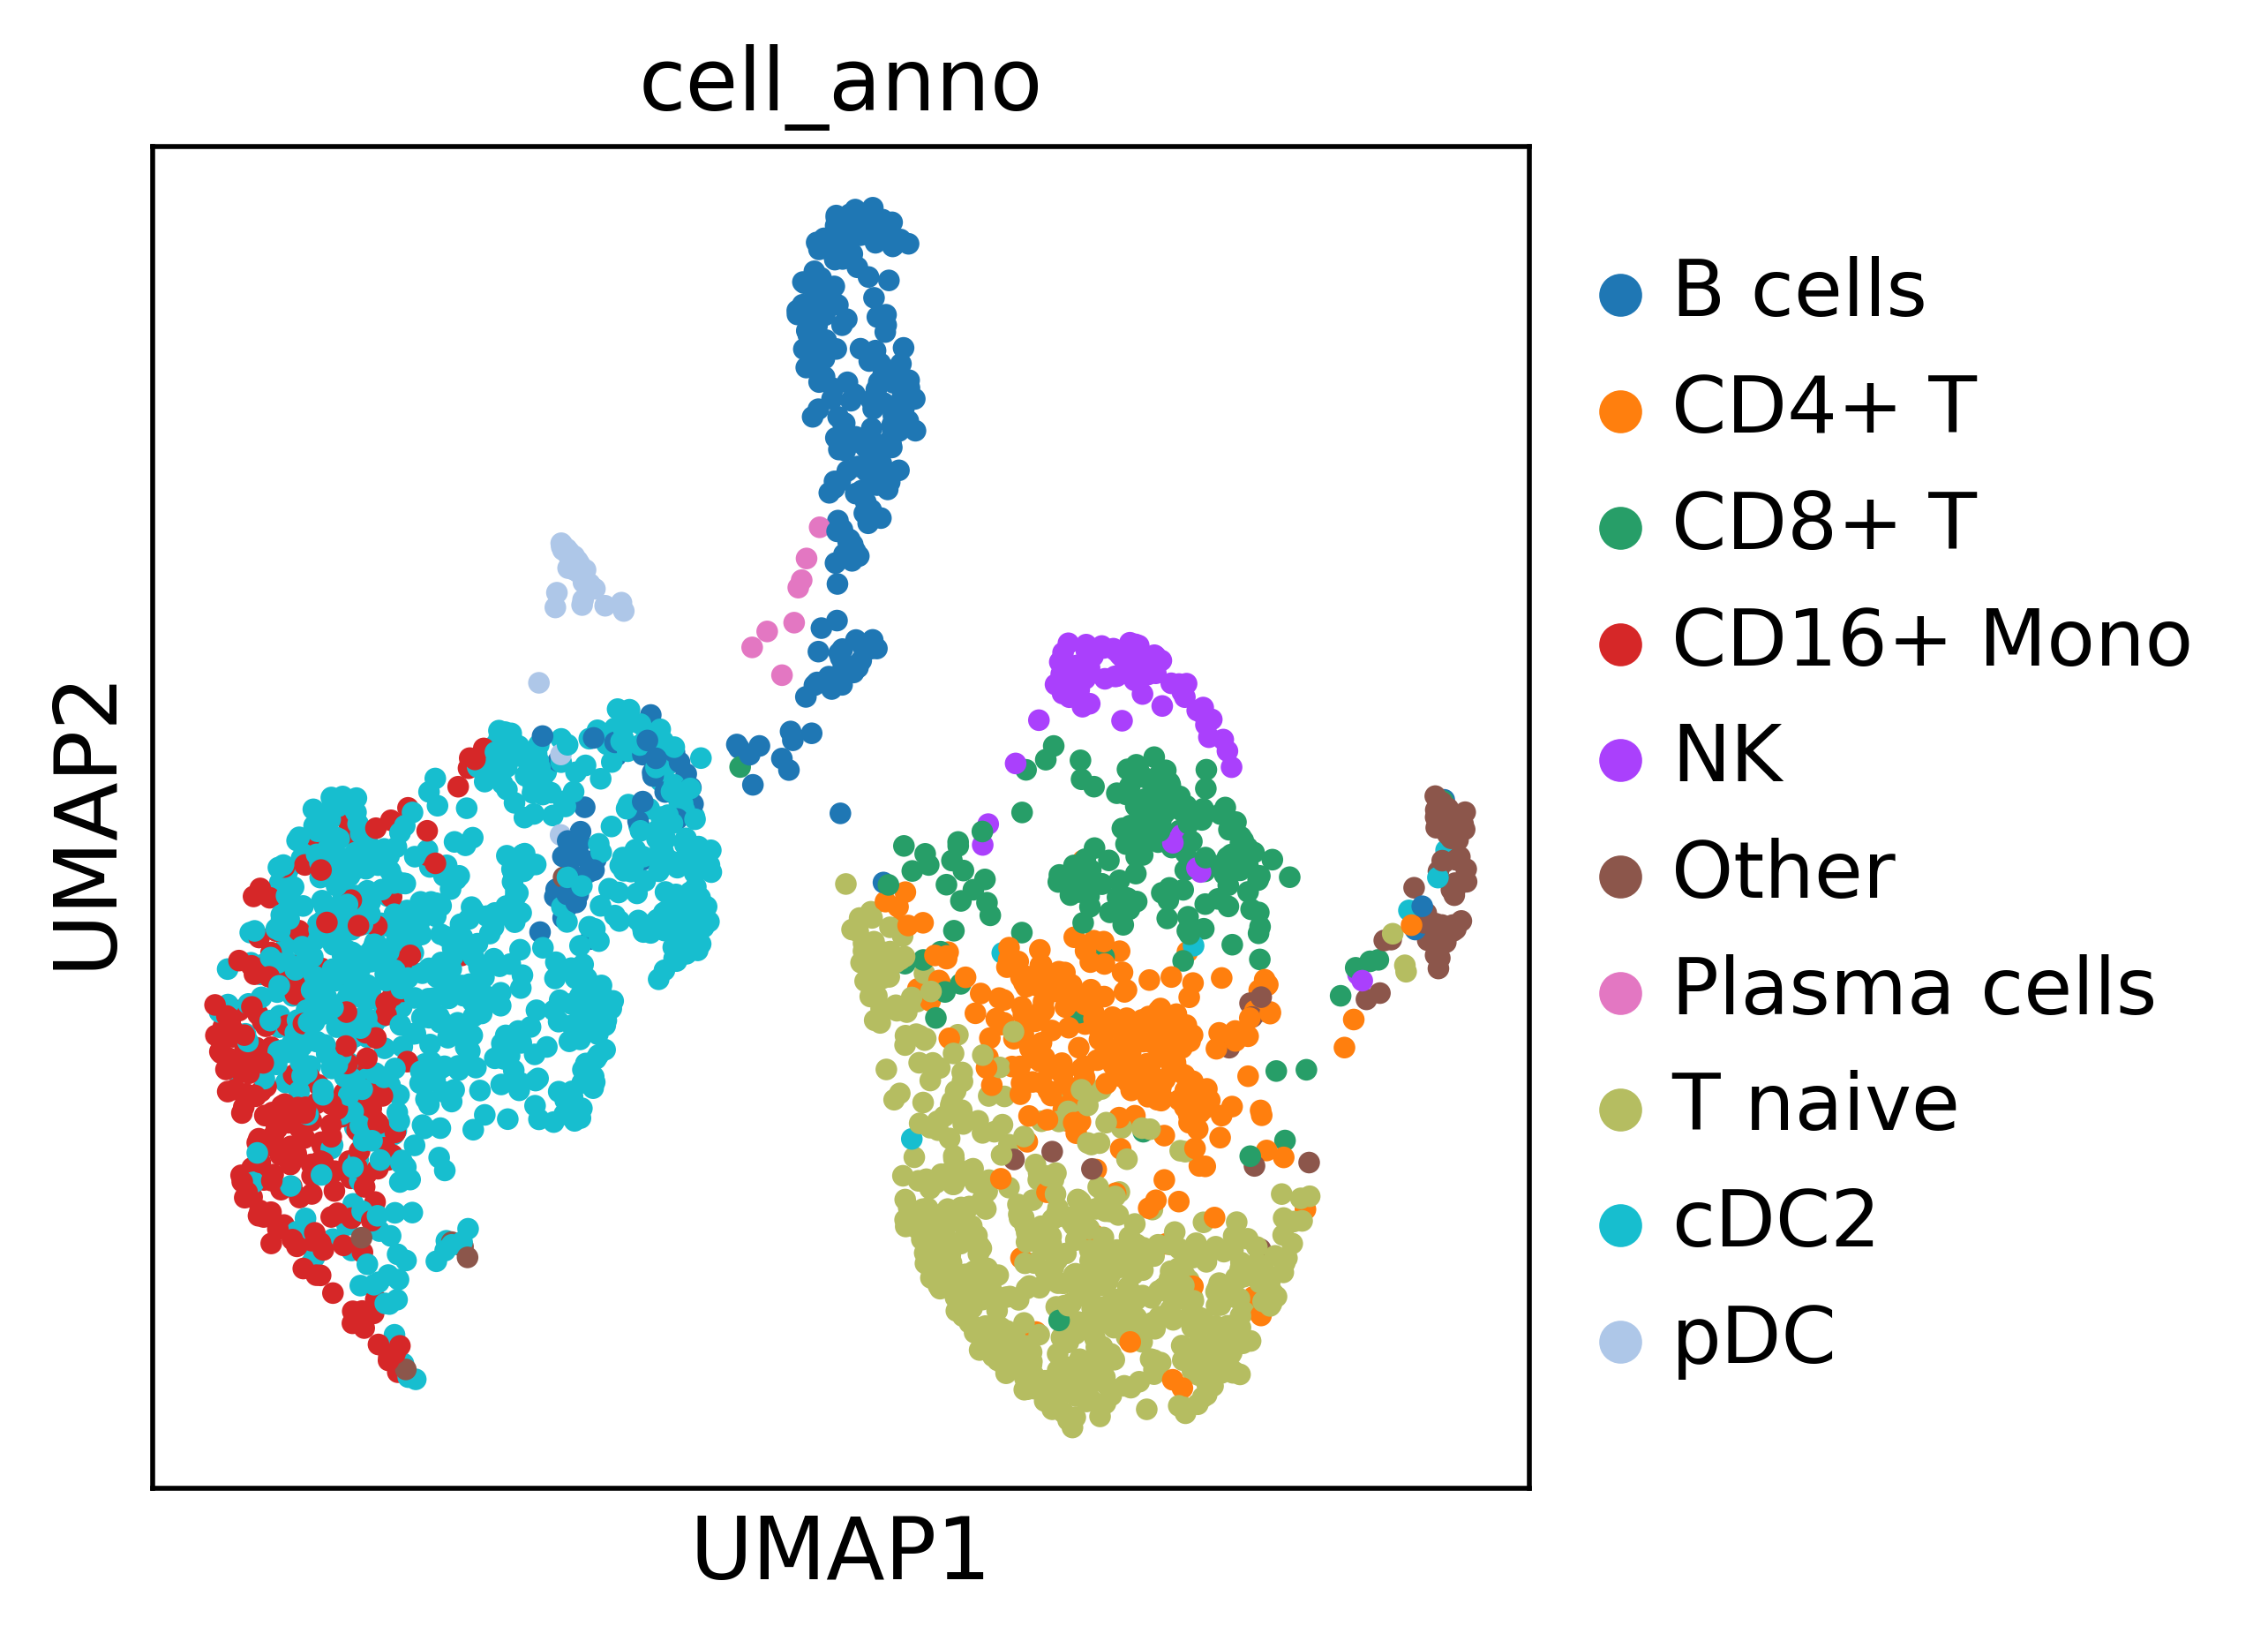

In [8]:
# raw source
raw_rna = umap(raw_rna, save_name=os.path.join(fig_output_dir, "raw_data_cluster"))

## 聚类AMI,ARI,HOM,NMI

/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Adjusted Mutual Information (AMI): 0.5731789621537492
Adjusted Rand Index (ARI): 0.3465070346956423
Homogeneity Score (HOM): 0.6084449474175668
Normalized Mutual Information (NMI): 0.5797289069870184


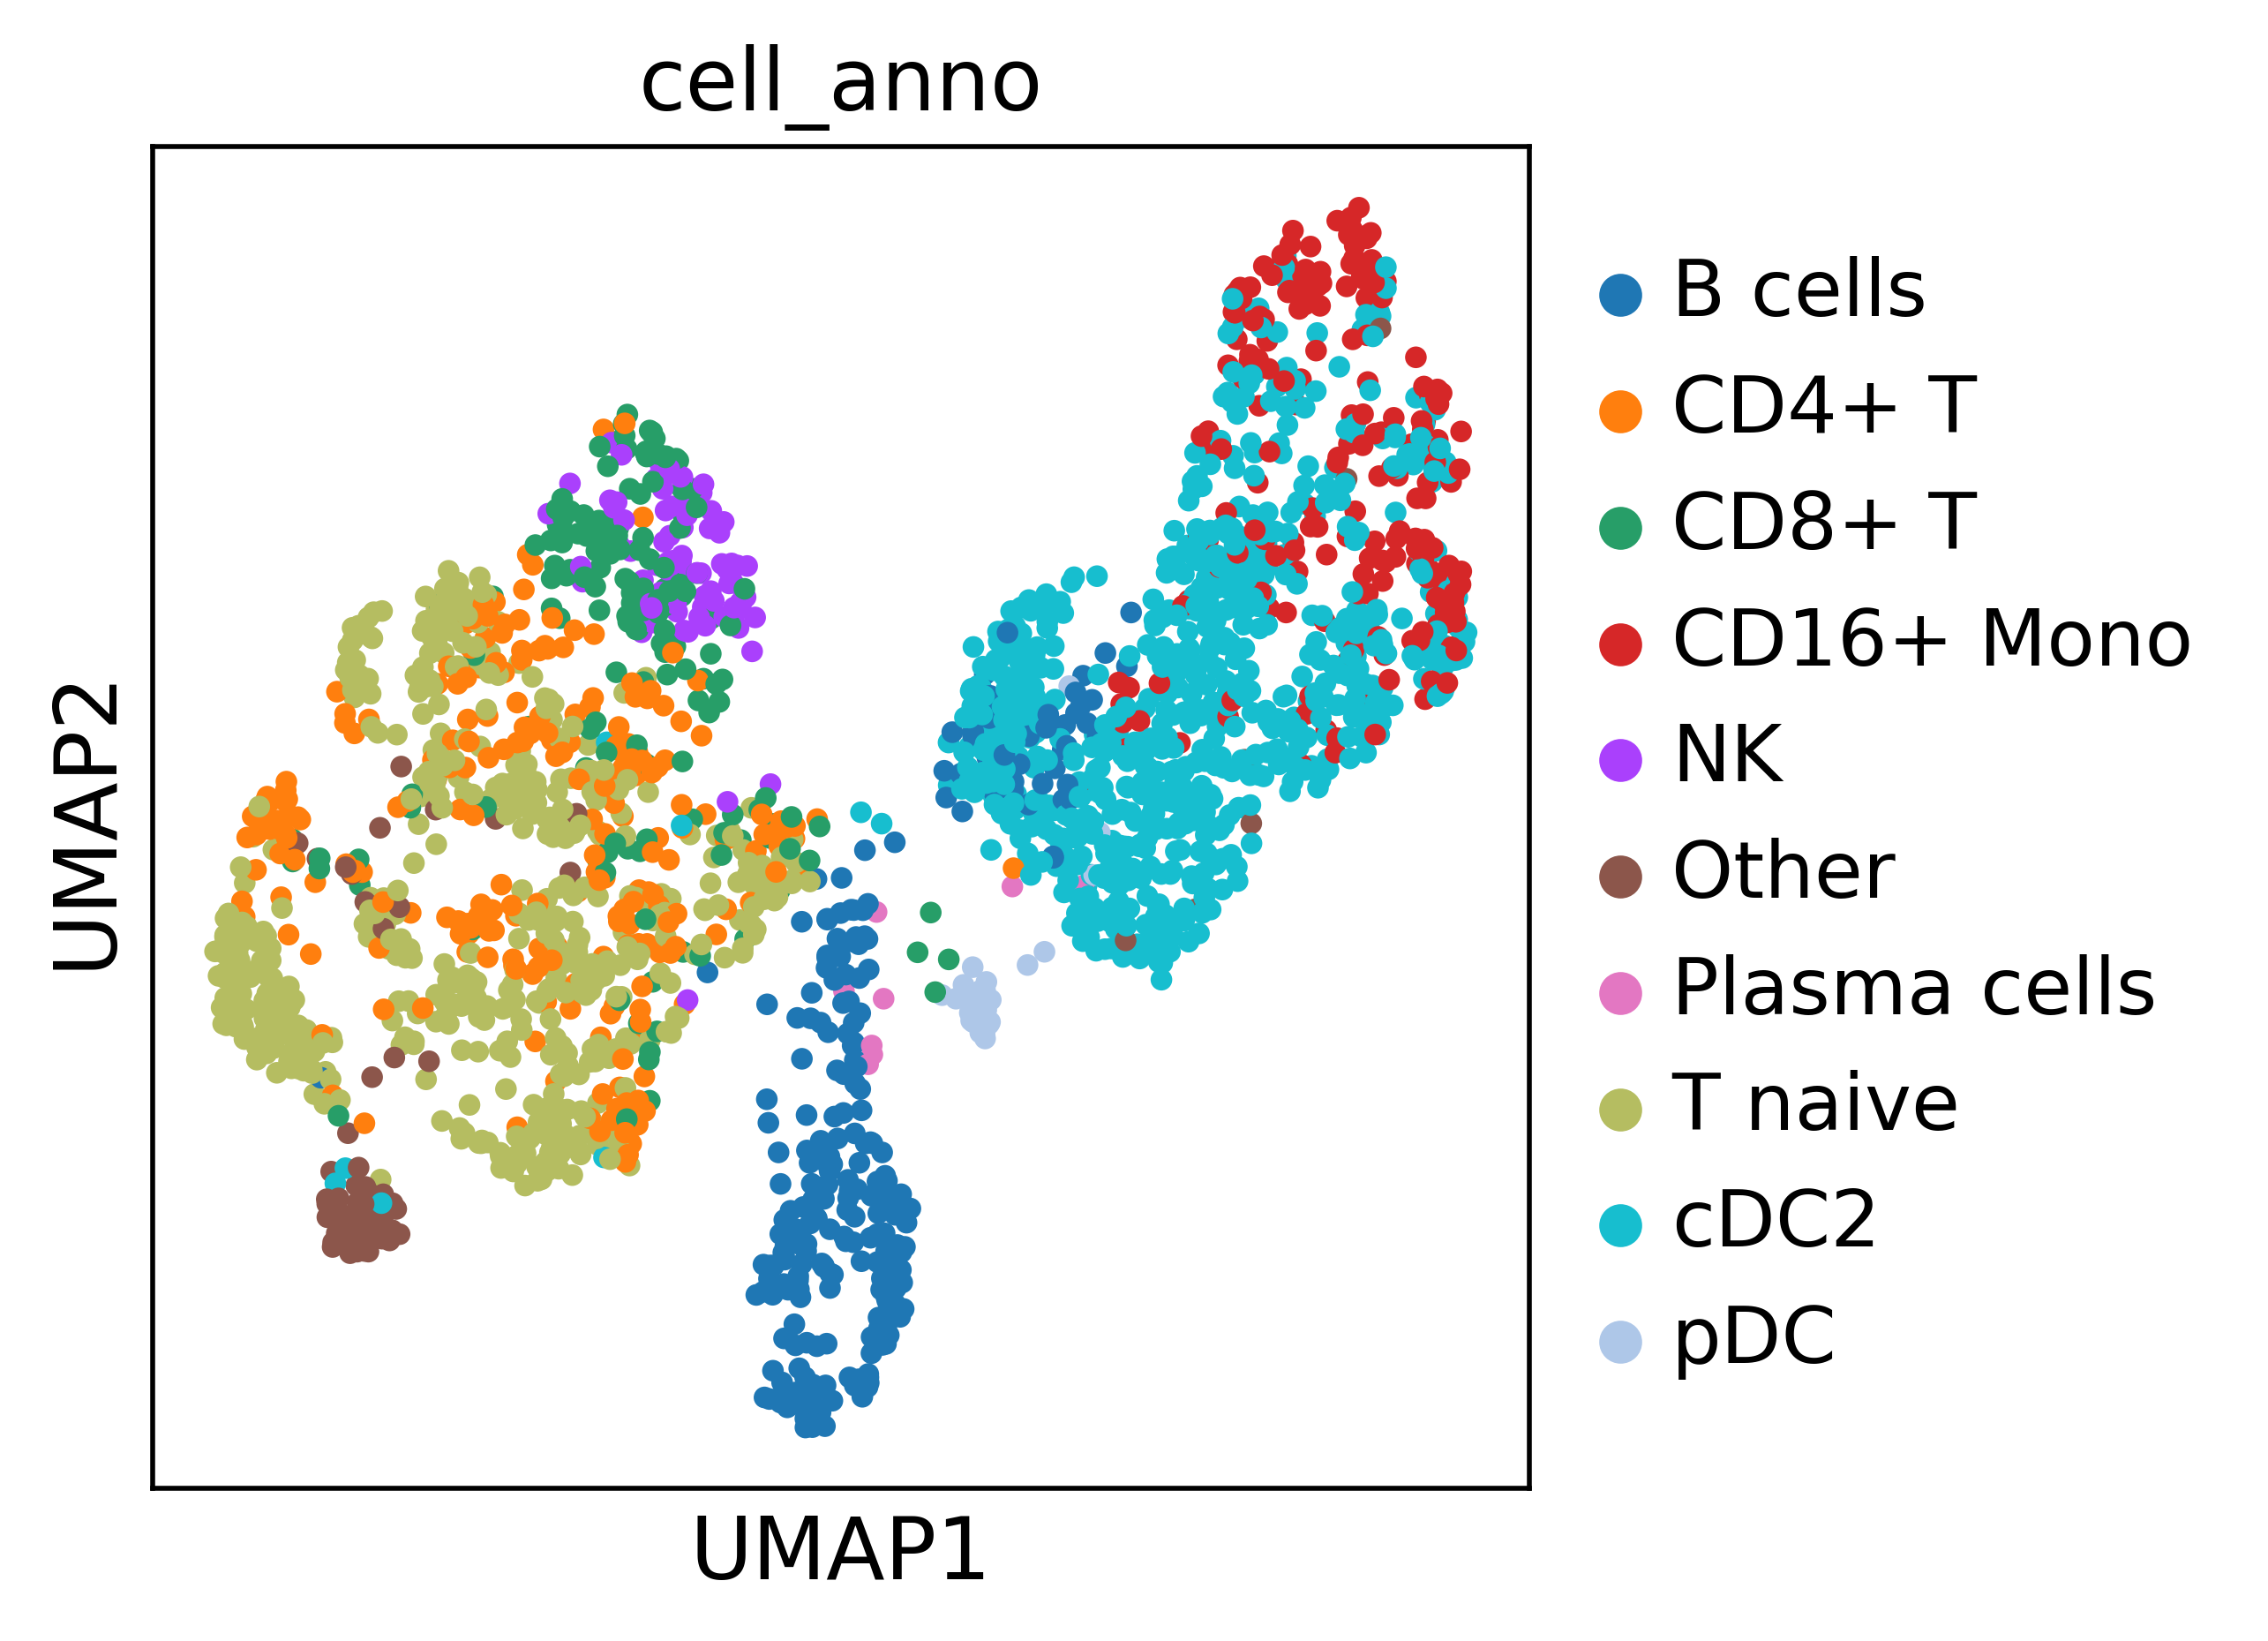

In [9]:
f_predict_rna, pf_raw_rna = intersect_adata(predict_rna, raw_rna)
f_predict_rna = umap(f_predict_rna, save_name=os.path.join(fig_output_dir, "predicted_rna_cluster"))
pf_raw_rna = umap(pf_raw_rna)
cisformer_ami, cisformer_ari, cisformer_homogeneity, cisformer_nmi = cluster_eval(f_predict_rna, pf_raw_rna)

# Compare correlation with data predicted by other tools

## Load data from other tools 
*Please check if the indices of obs and var are the same format as raw_rna*

In [9]:
# ArchR
archr_rna = sc.AnnData(archr_rna)
archr_rna.X = csr_matrix(archr_rna.X)
archr_rna.obs.index = [each.split("#")[1] for each in archr_rna.obs.index]

# Scarlink
scarlink_rna = sc.AnnData(scarlink_rna)
scarlink_rna.X = csr_matrix(scarlink_rna.X)

# scButterfly
with open(scbutterfly_gene_list_file, "r") as f:
    scbutterfly_gene_list = [each.strip() for each in f.readlines()]
scbutterfly_rna.var.index = scbutterfly_gene_list
scbutterfly_rna.obs.index = [each[:-2] for each in scbutterfly_rna.obs.index]

/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/anndata/utils.py:307: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


### UMAP and Corr

#### ArchR

/tmp/ipykernel_36225/208696019.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f_archr_rna.obs['cell_anno'] = cell_info.loc[f_archr_rna.obs_names, :]
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Adjusted Mutual Information (AMI): 0.5979316703663723
Adjusted Rand Index (ARI): 0.43523037940593023
Homogeneity Score (HOM): 0.5802616383177974
Normalized Mutual Information (NMI): 0.6040475604338001


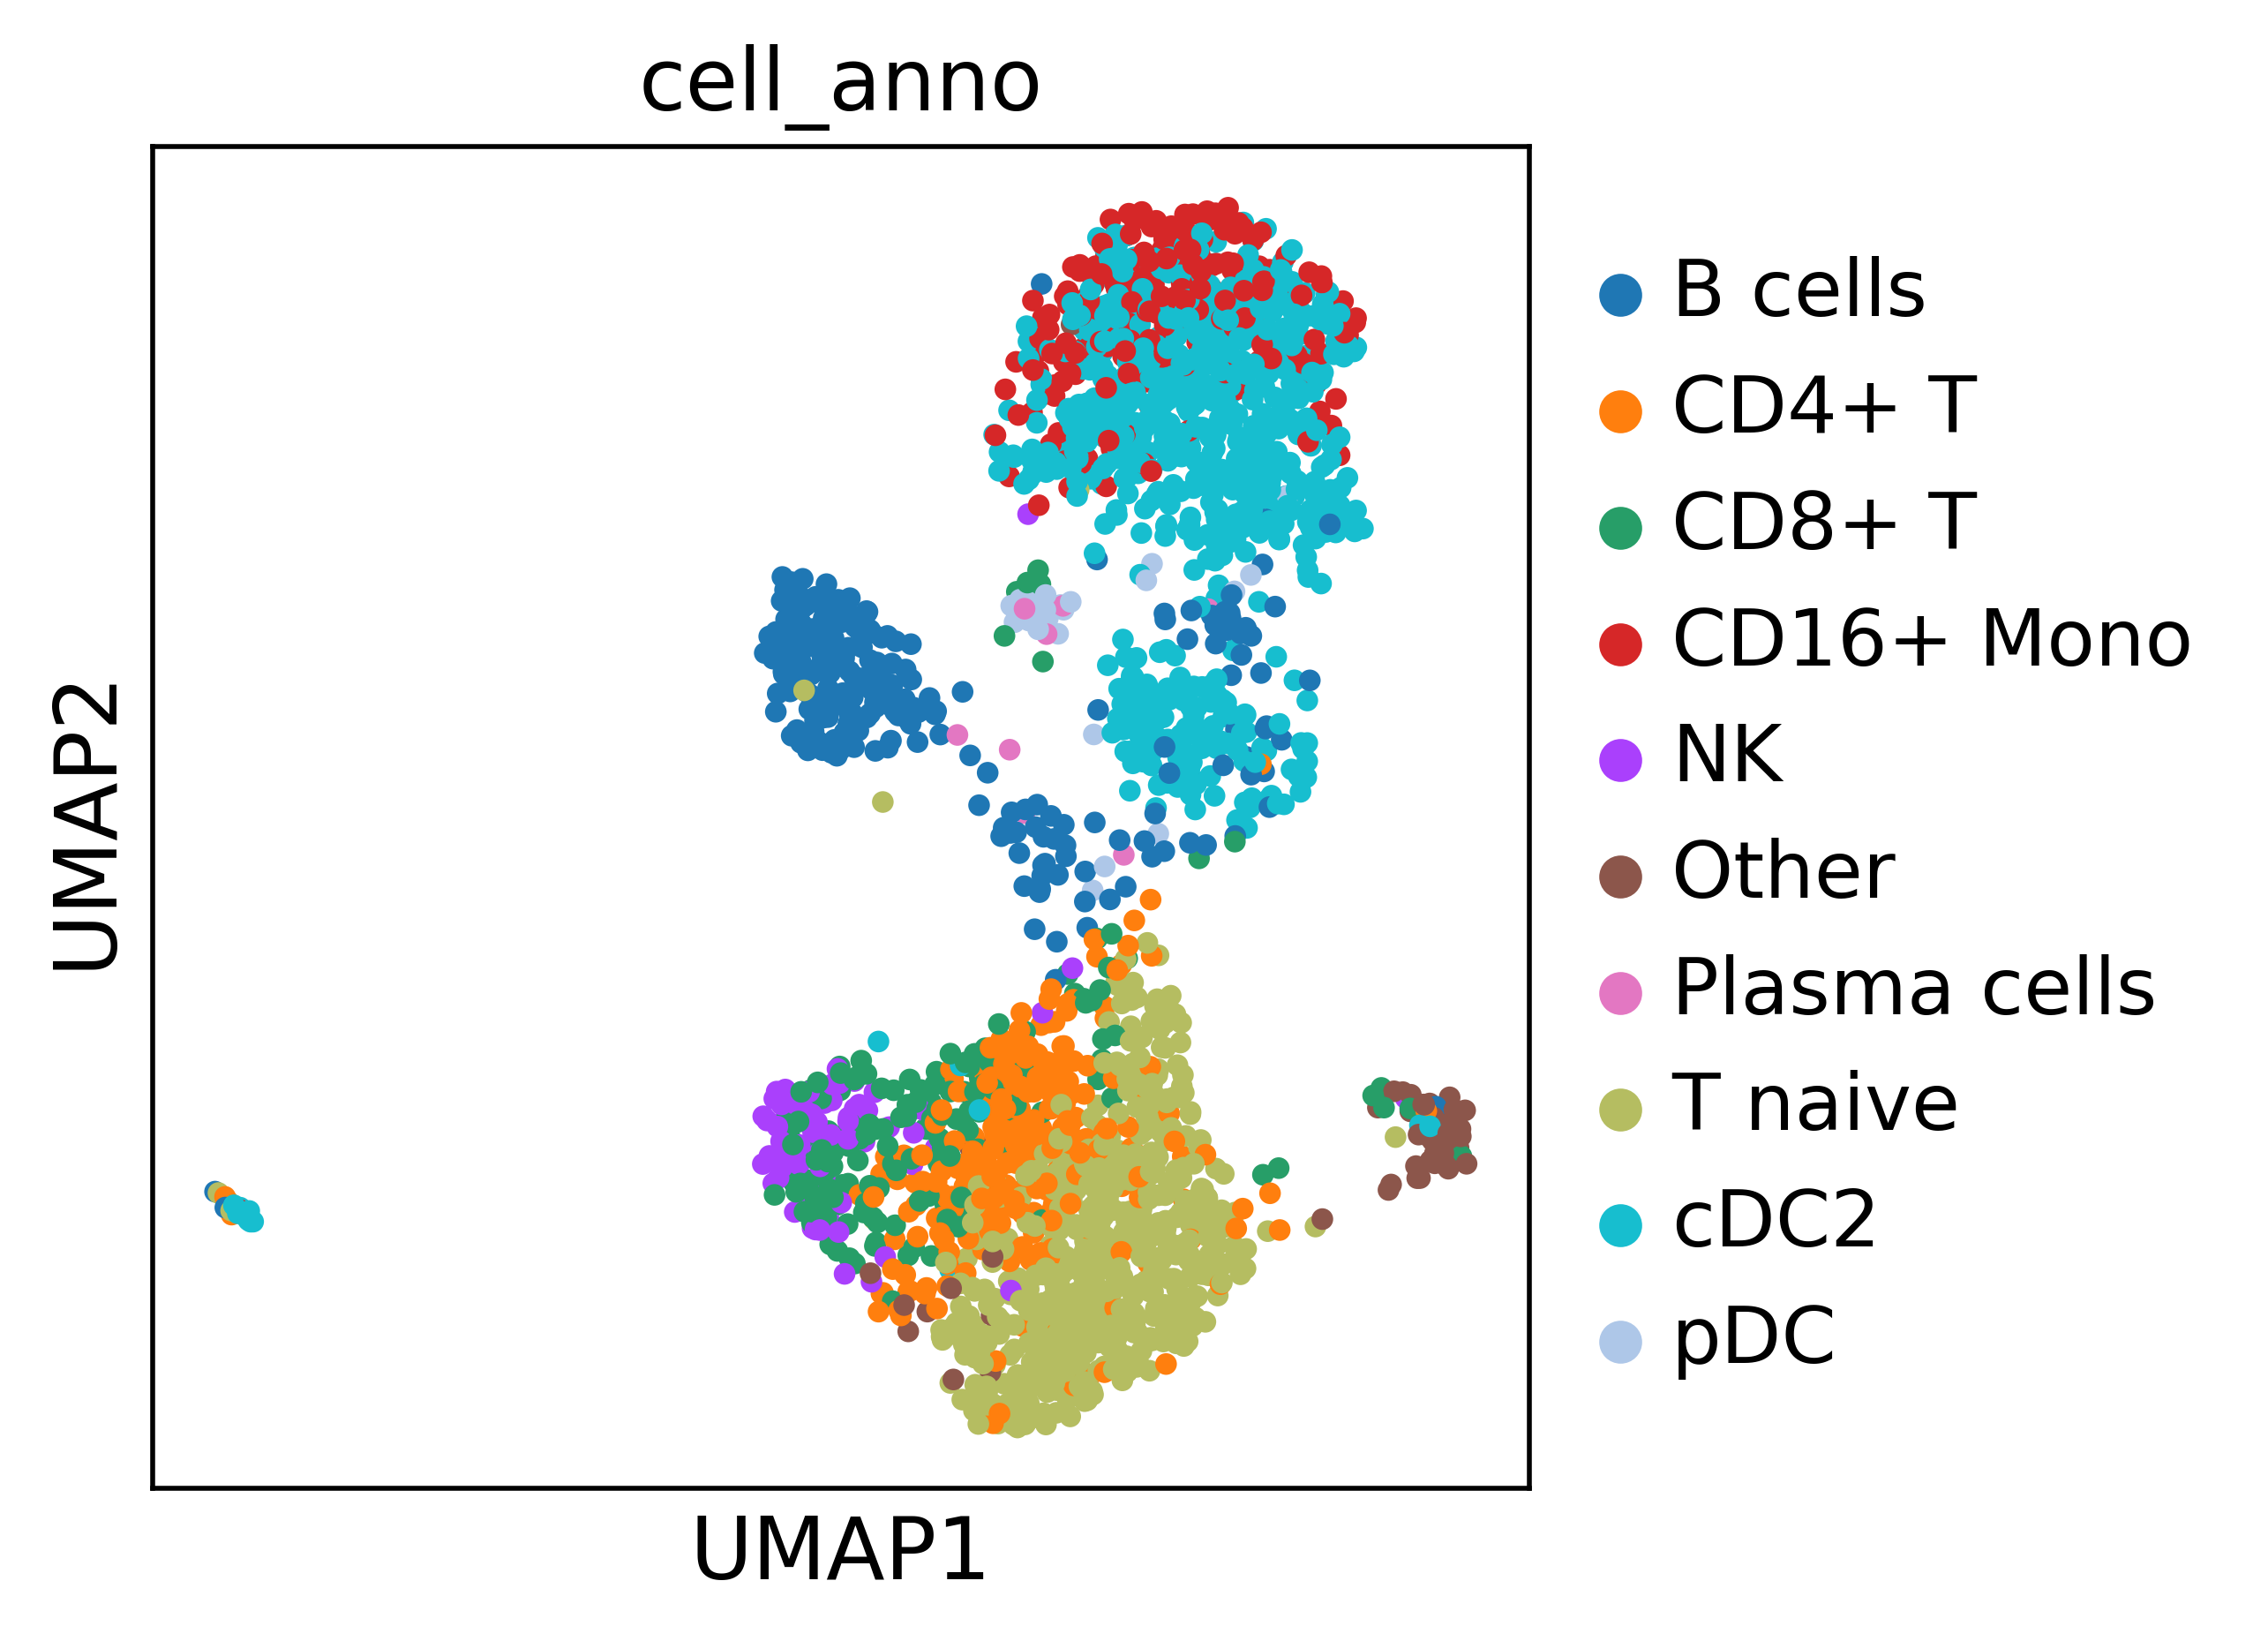

In [11]:
f_archr_rna, Af_raw_rna = intersect_adata(archr_rna, raw_rna)
f_archr_rna.obs['cell_anno'] = cell_info.loc[f_archr_rna.obs_names, :]
f_archr_rna.X[Af_raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
f_archr_rna = umap(f_archr_rna, save_name=os.path.join(fig_output_dir, "ArchR_predicted_rna_cluster"))
Af_raw_rna = umap(Af_raw_rna)
archr_ami, archr_ari, archr_homogeneity, archr_nmi = cluster_eval(f_archr_rna, Af_raw_rna)

#### Scarlink

/tmp/ipykernel_36225/2114263217.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f_scarlink_rna.obs['cell_anno'] = cell_info.loc[scarf_raw_rna.obs_names, :]
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Adjusted Mutual Information (AMI): 0.30220025695221575
Adjusted Rand Index (ARI): 0.12997821654582767
Homogeneity Score (HOM): 0.332470325818677
Normalized Mutual Information (NMI): 0.3128558228933363


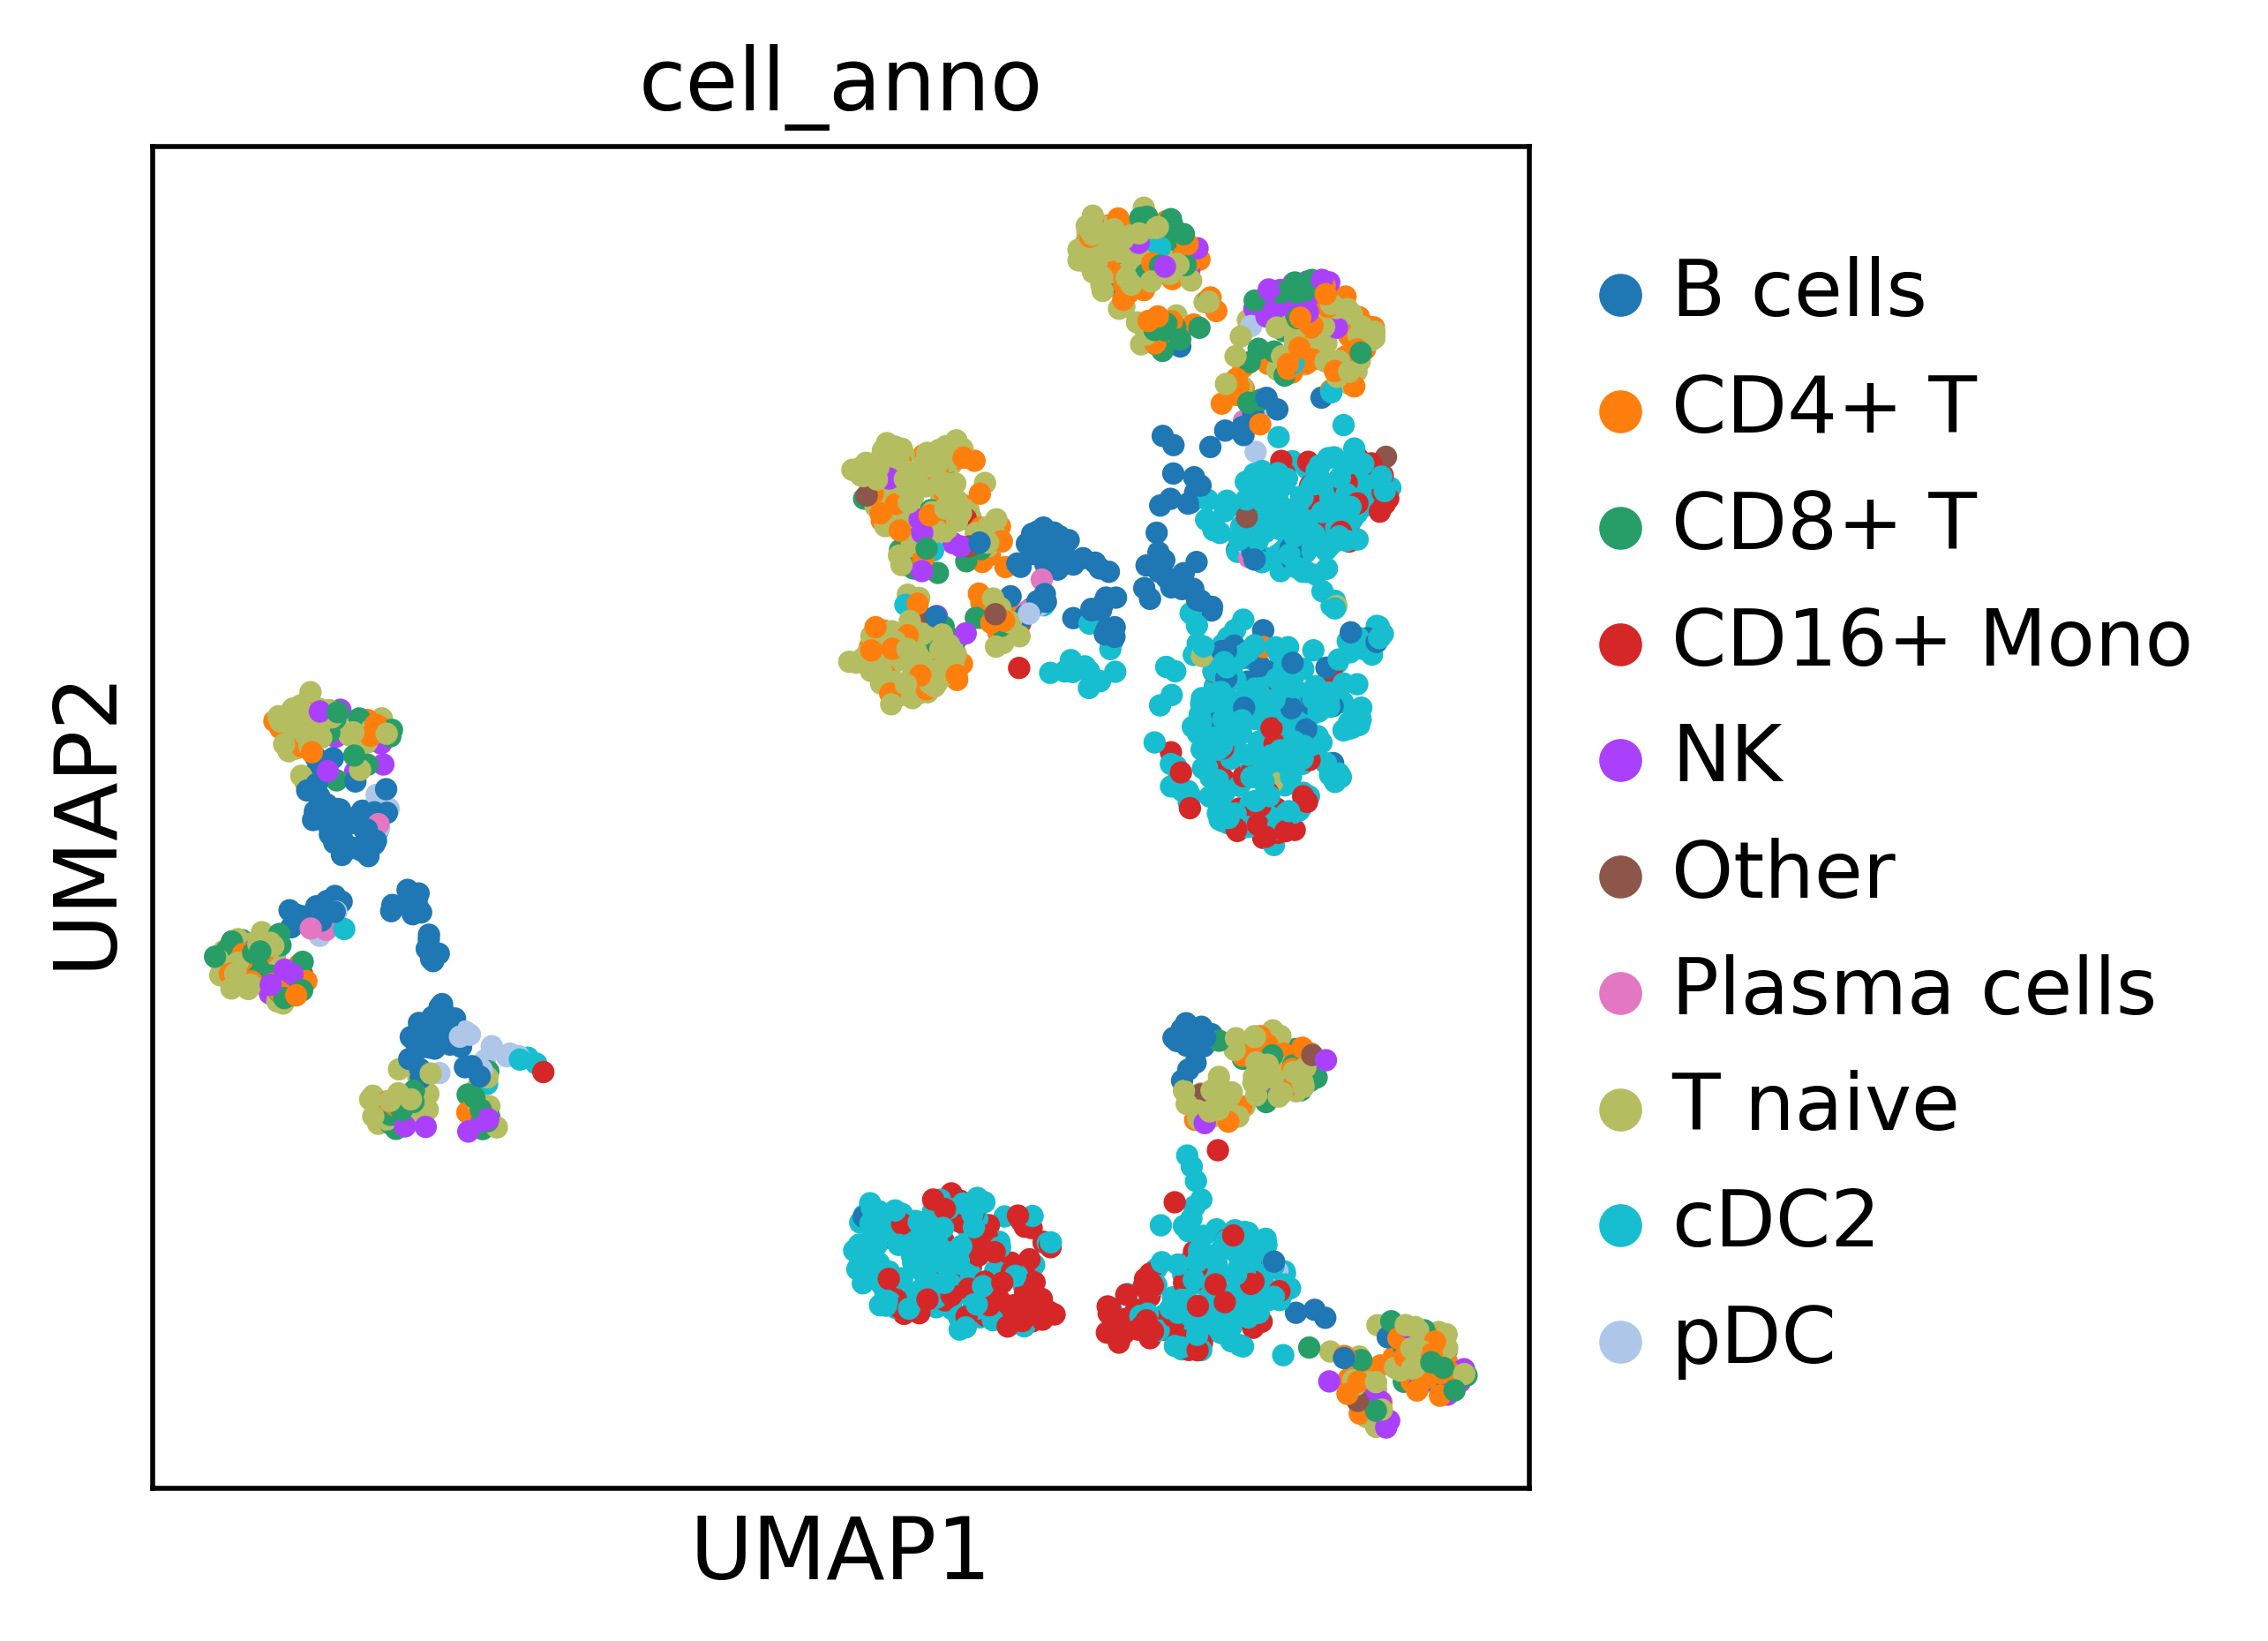

In [13]:
f_scarlink_rna, scarf_raw_rna = intersect_adata(scarlink_rna, raw_rna)
f_scarlink_rna.obs['cell_anno'] = cell_info.loc[scarf_raw_rna.obs_names, :]
f_scarlink_rna.X[scarf_raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
f_scarlink_rna = umap(f_scarlink_rna, save_name = os.path.join(fig_output_dir, "Scarlink_predicted_rna_cluster"))
scarf_raw_rna = umap(scarf_raw_rna)
scarlink_ami, scarlink_ari, scarlink_homogeneity, scarlink_nmi = cluster_eval(f_scarlink_rna, scarf_raw_rna)

#### scButterfly

/tmp/ipykernel_36225/168326599.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f_scbutterfly_rna.obs['cell_anno'] = cell_info.loc[f_scbutterfly_rna.obs_names, :]
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Adjusted Mutual Information (AMI): 0.6560077794893803
Adjusted Rand Index (ARI): 0.5071734697114463
Homogeneity Score (HOM): 0.6583138894896726
Normalized Mutual Information (NMI): 0.6615018808531136


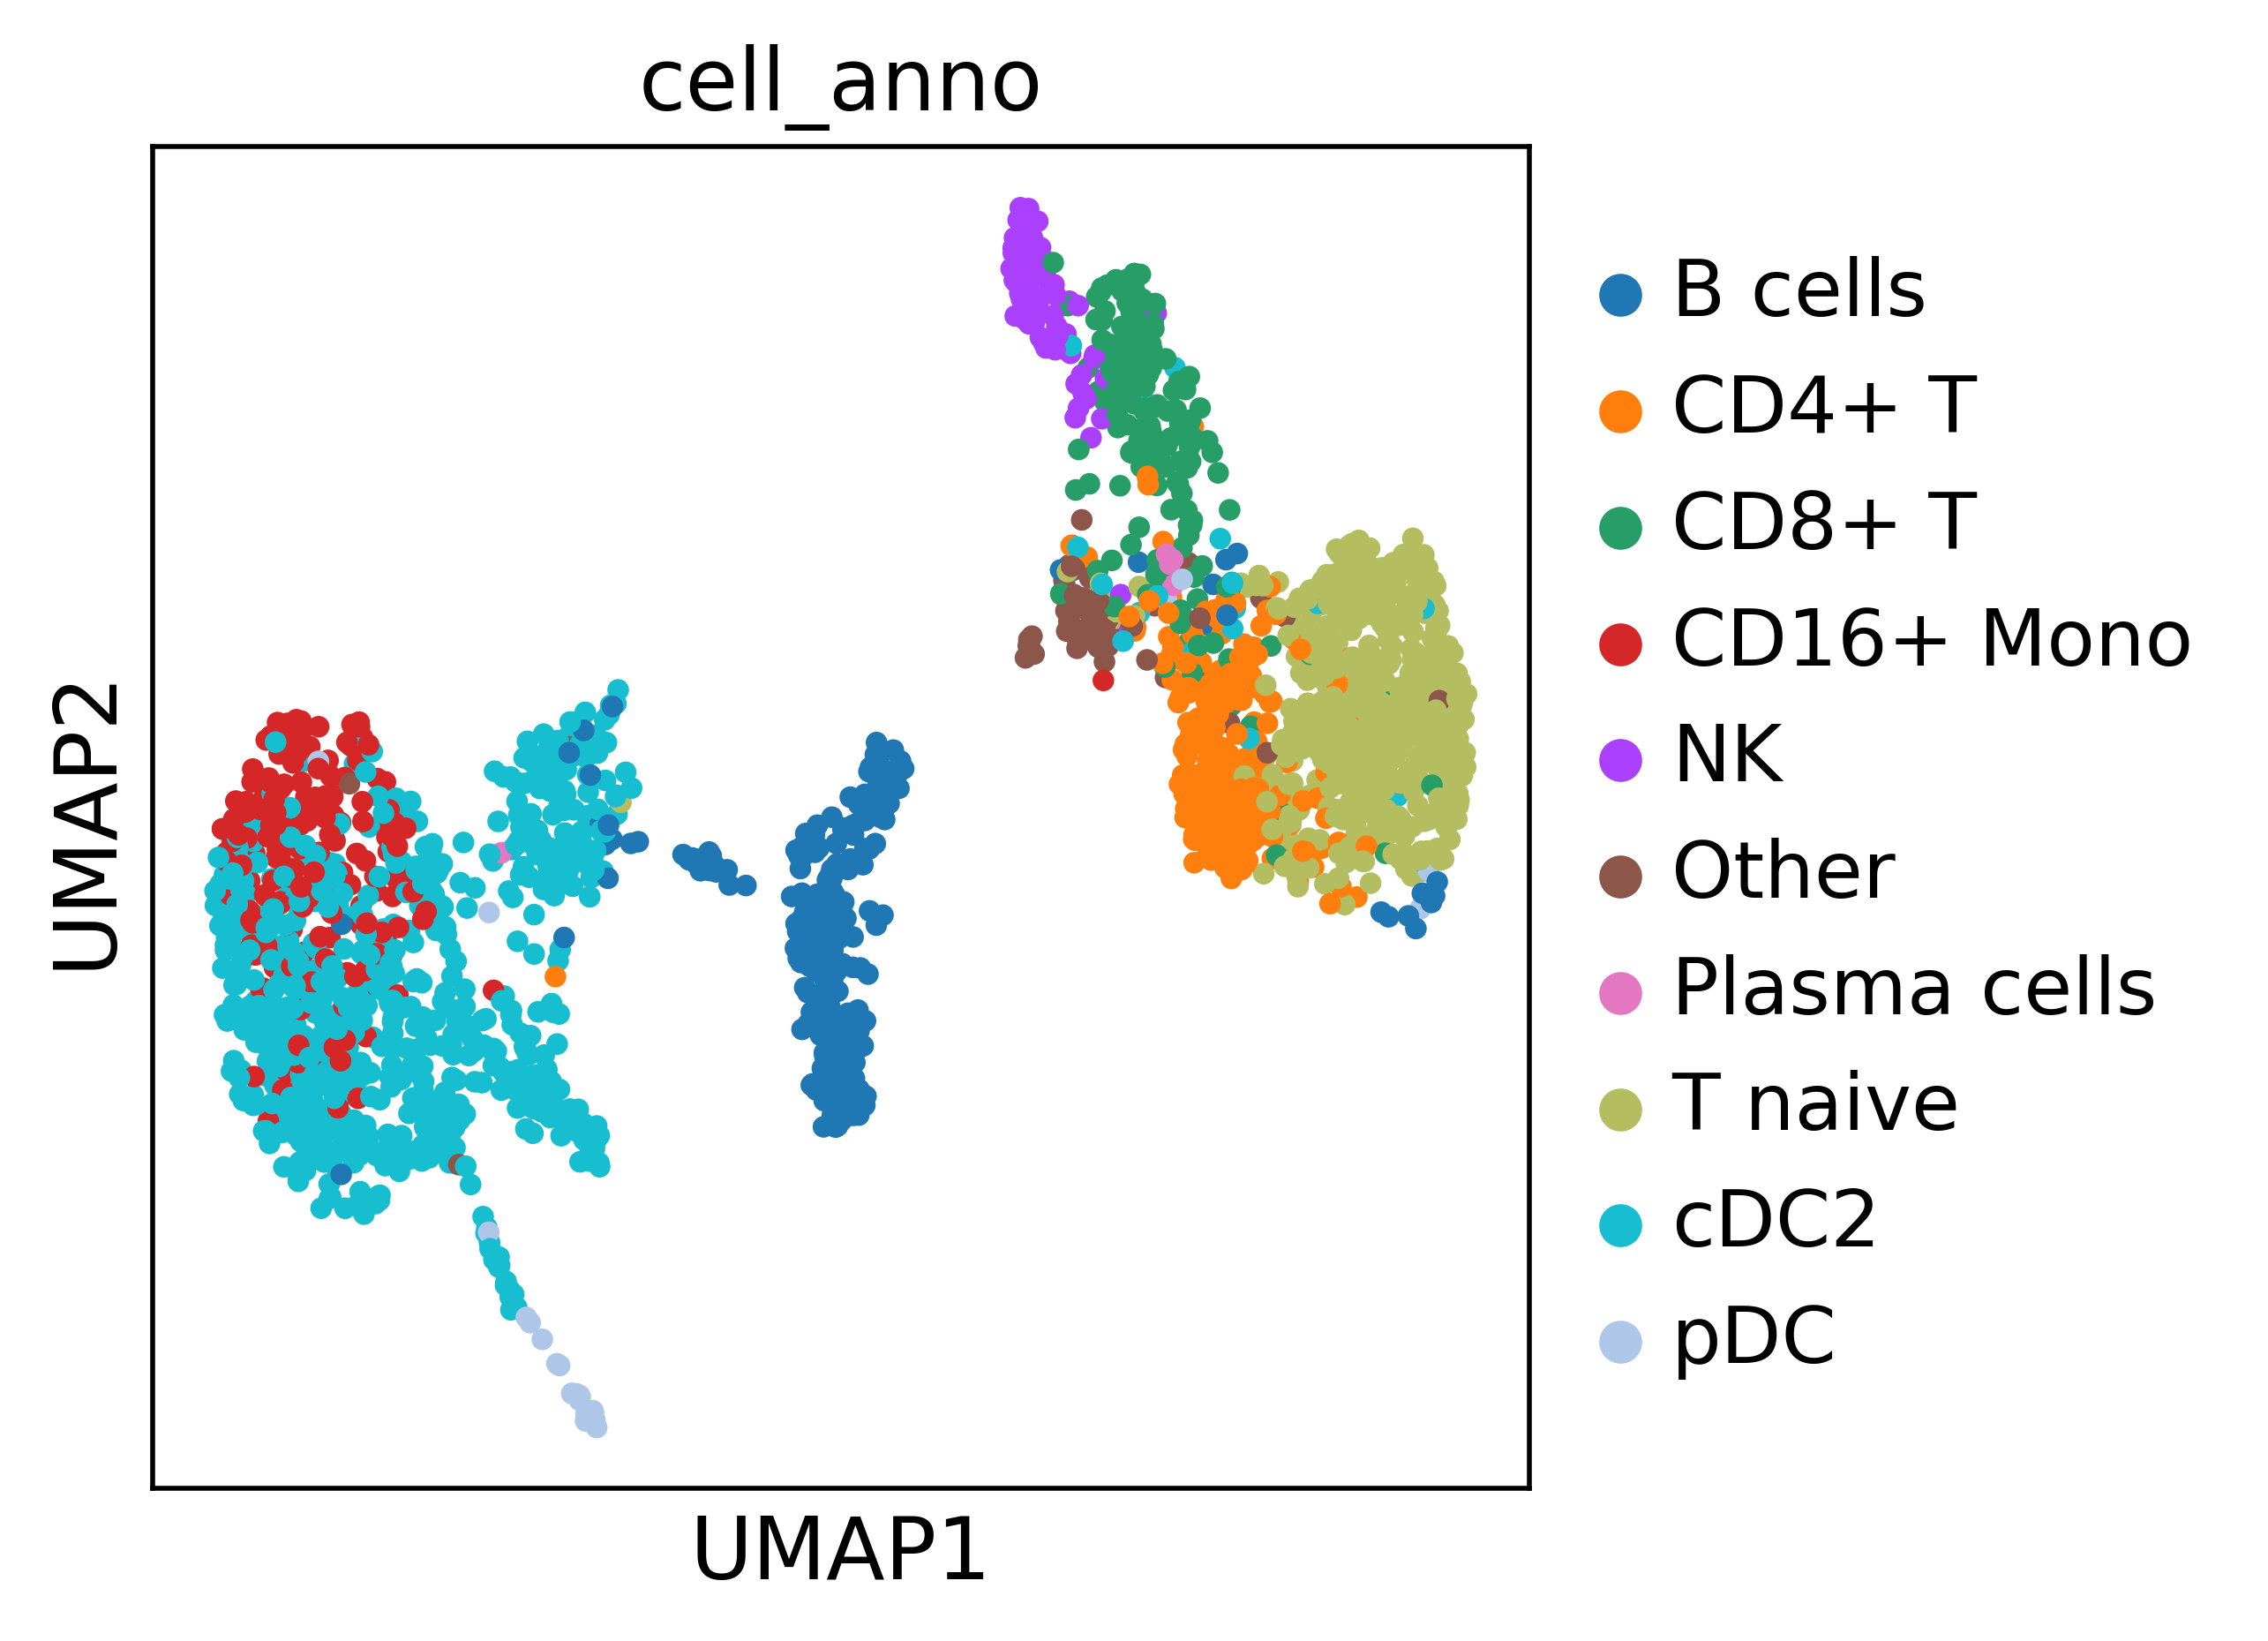

In [15]:
f_scbutterfly_rna, scbf_raw_rna = intersect_adata(scbutterfly_rna, raw_rna)
f_scbutterfly_rna.obs['cell_anno'] = cell_info.loc[f_scbutterfly_rna.obs_names, :]
f_scbutterfly_rna.X[scbf_raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
f_scbutterfly_rna = umap(f_scbutterfly_rna, save_name = os.path.join(fig_output_dir, "scButterfly_predicted_rna_cluster"))
scbf_raw_rna = umap(scbf_raw_rna)
scbutterfly_ami, scbutterfly_ari, scbutterfly_homogeneity, scbutterfly_nmi = cluster_eval(f_scbutterfly_rna, scbf_raw_rna)

#### RPmodel

/tmp/ipykernel_36225/3332518173.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f_rp_rna.obs['cell_anno'] = cell_info.loc[f_rp_rna.obs_names, :]
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Adjusted Mutual Information (AMI): 0.48720993134468243
Adjusted Rand Index (ARI): 0.3100363994670276
Homogeneity Score (HOM): 0.49545965813029963
Normalized Mutual Information (NMI): 0.4942015554300712


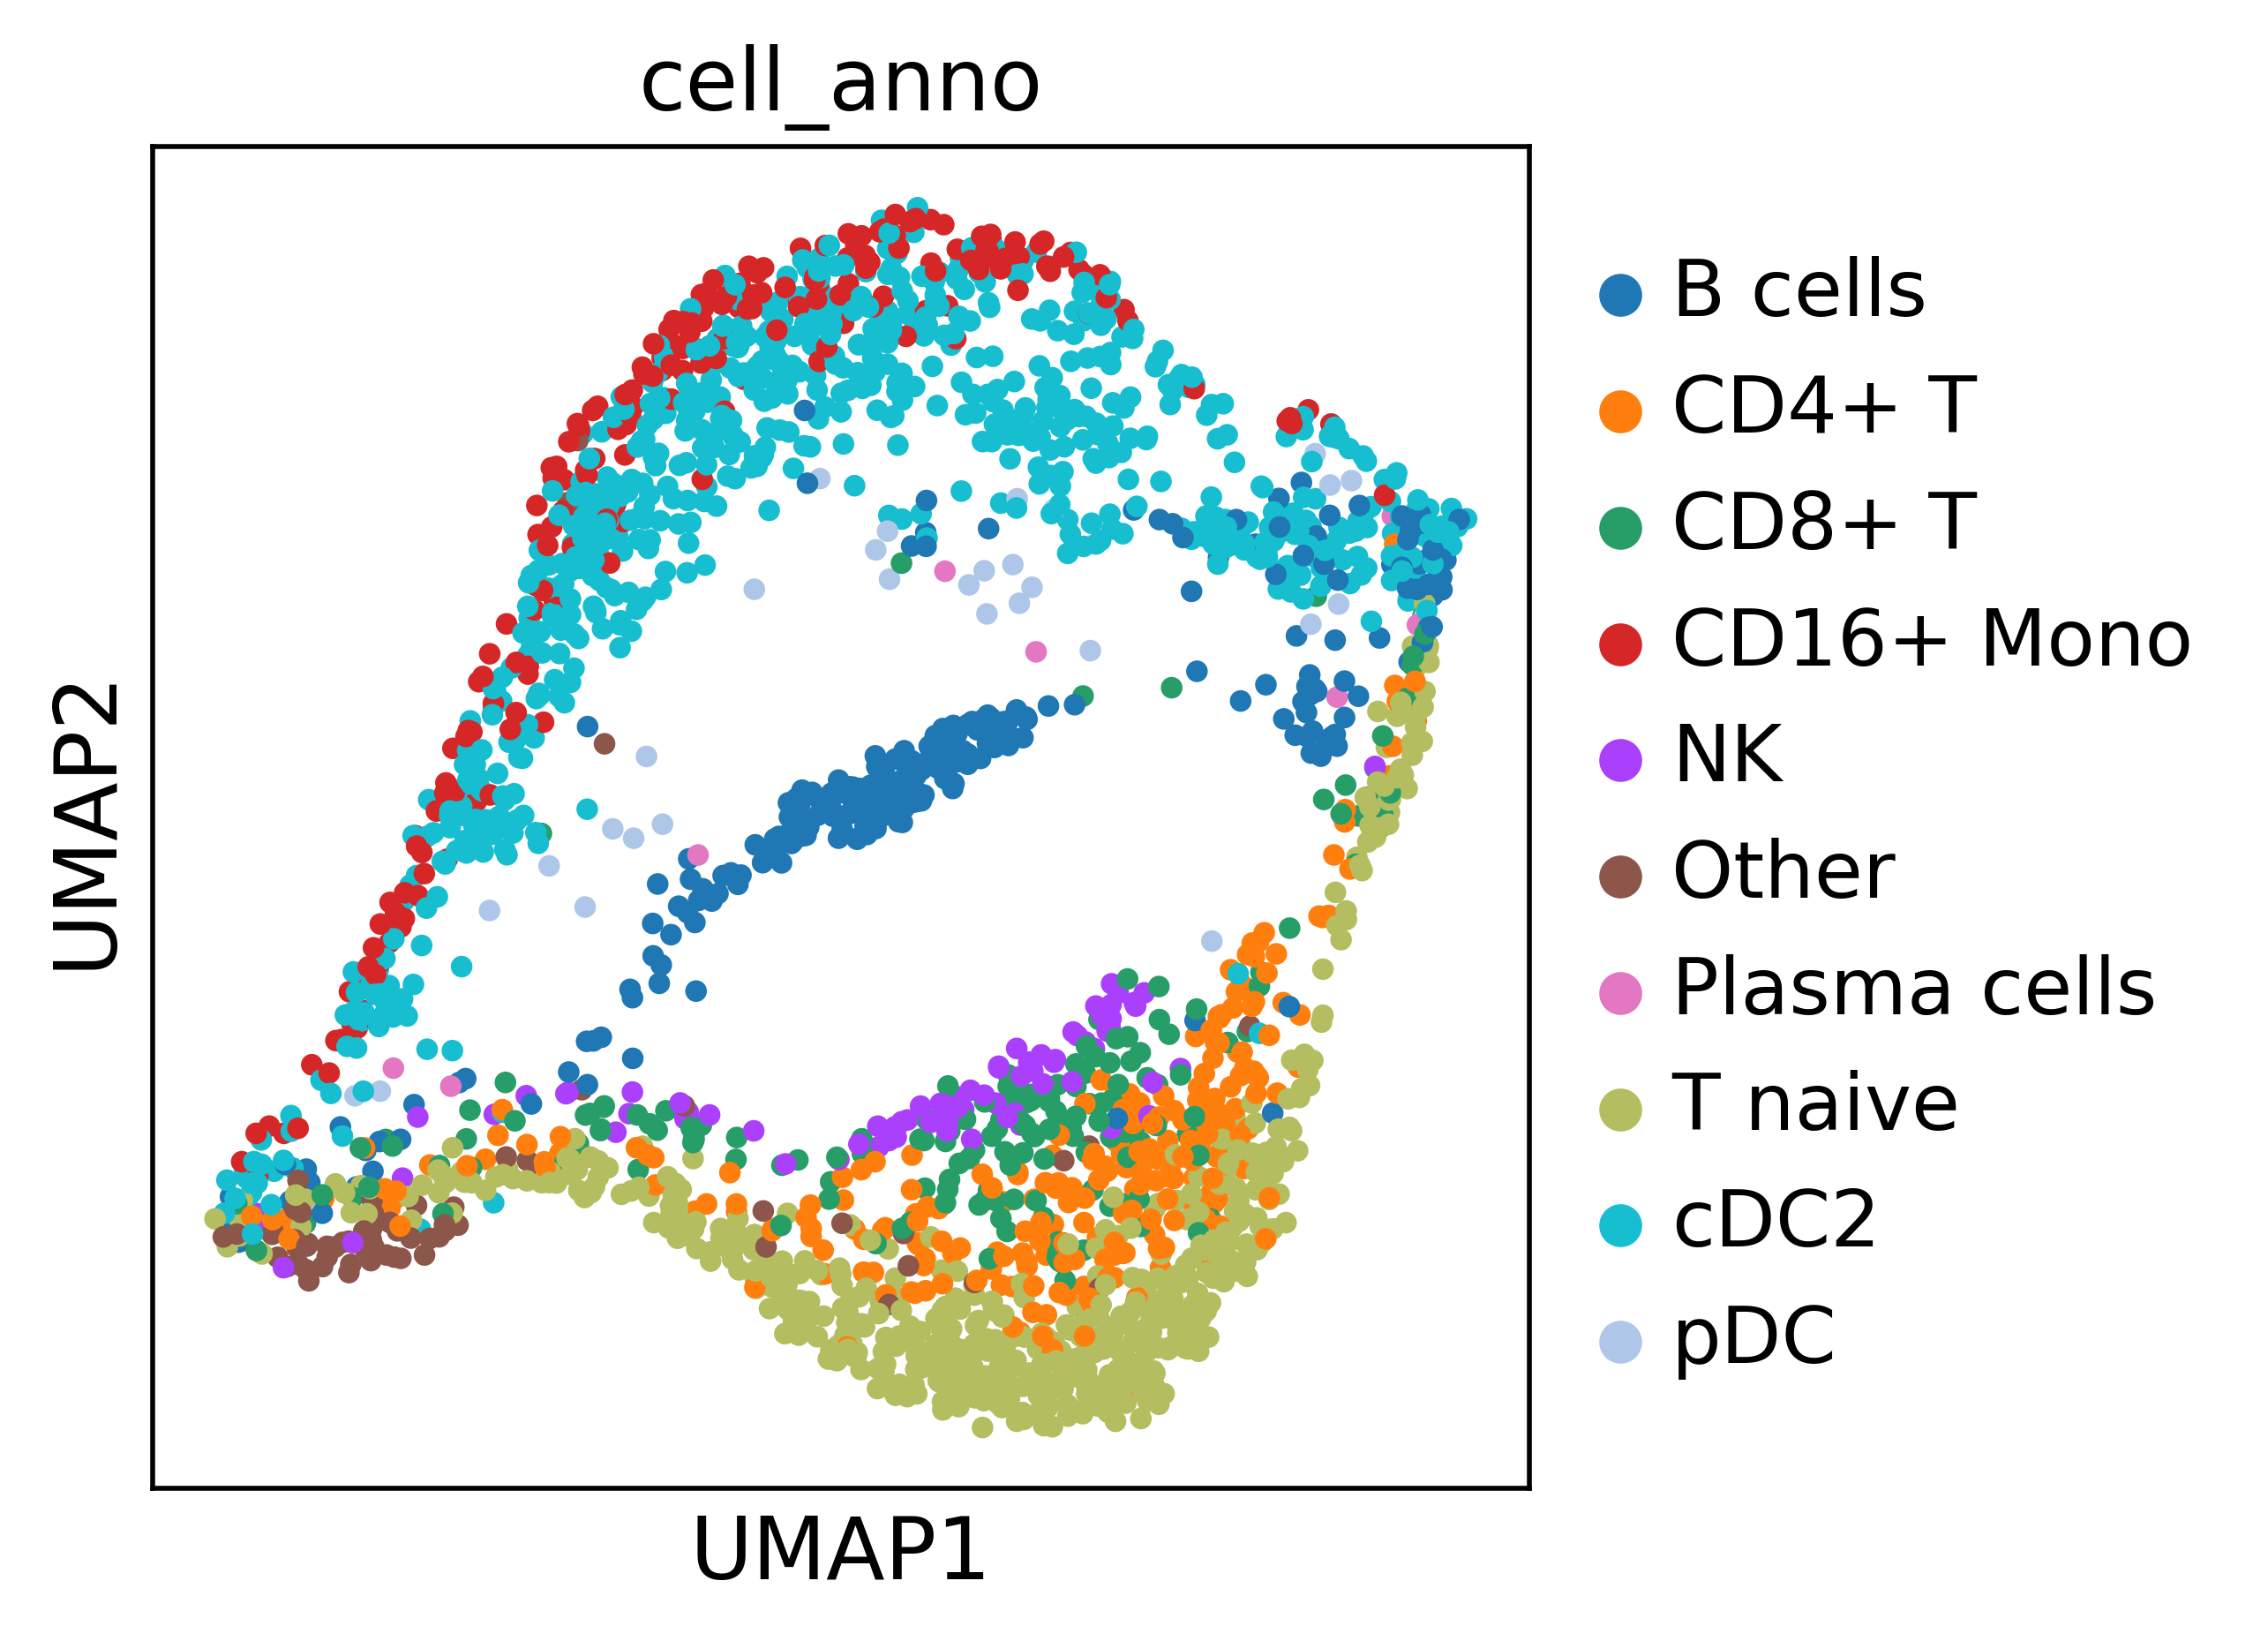

In [16]:
f_rp_rna, rp_raw_rna = intersect_adata(rp_rna, raw_rna)
f_rp_rna.obs['cell_anno'] = cell_info.loc[f_rp_rna.obs_names, :]
f_rp_rna.X = csr_matrix(f_rp_rna.X)
f_rp_rna.X[rp_raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
f_rp_rna = umap(f_rp_rna, save_name = os.path.join(fig_output_dir, "RPmodel_predicted_rna_cluster"))
rp_raw_rna = umap(rp_raw_rna)
rp_ami, rp_ari, rp_homogeneity, rp_nmi = cluster_eval(f_rp_rna, rp_raw_rna)

## Comparing

In [17]:
testing_models = ["cisformer", "archr", "scarlink", "scbutterfly", "rp"]

### Cluster evaluate

In [18]:
cluster_eval_table = {}
for each in testing_models:
    exec(f"cluster_eval_table['{each}'] = [{each}_ami, {each}_ari, {each}_homogeneity, {each}_nmi]")
cluster_eval_table_pd = pd.DataFrame(cluster_eval_table, index = ["AMI", "NMI", "ARI", "HOM"])
cluster_eval_table_pd = cluster_eval_table_pd.T
cluster_eval_table_pd.index = ['Cisformer', 'ArchR', 'Scarlink', 'scButterfly', 'RPmodel']
sort_idx = cluster_eval_table_pd.mean(axis=1).argsort()
cluster_eval_table_pd = cluster_eval_table_pd.iloc[sort_idx,:]

In [19]:
cluster_eval_table_pd

AMI       NMI       ARI       HOM
Scarlink     0.302200  0.129978  0.332470  0.312856
RPmodel      0.487210  0.310036  0.495460  0.494202
Cisformer    0.573179  0.346507  0.608445  0.579729
ArchR        0.597932  0.435230  0.580262  0.604048
scButterfly  0.656008  0.507173  0.658314  0.661502

画Bar-Plot展示

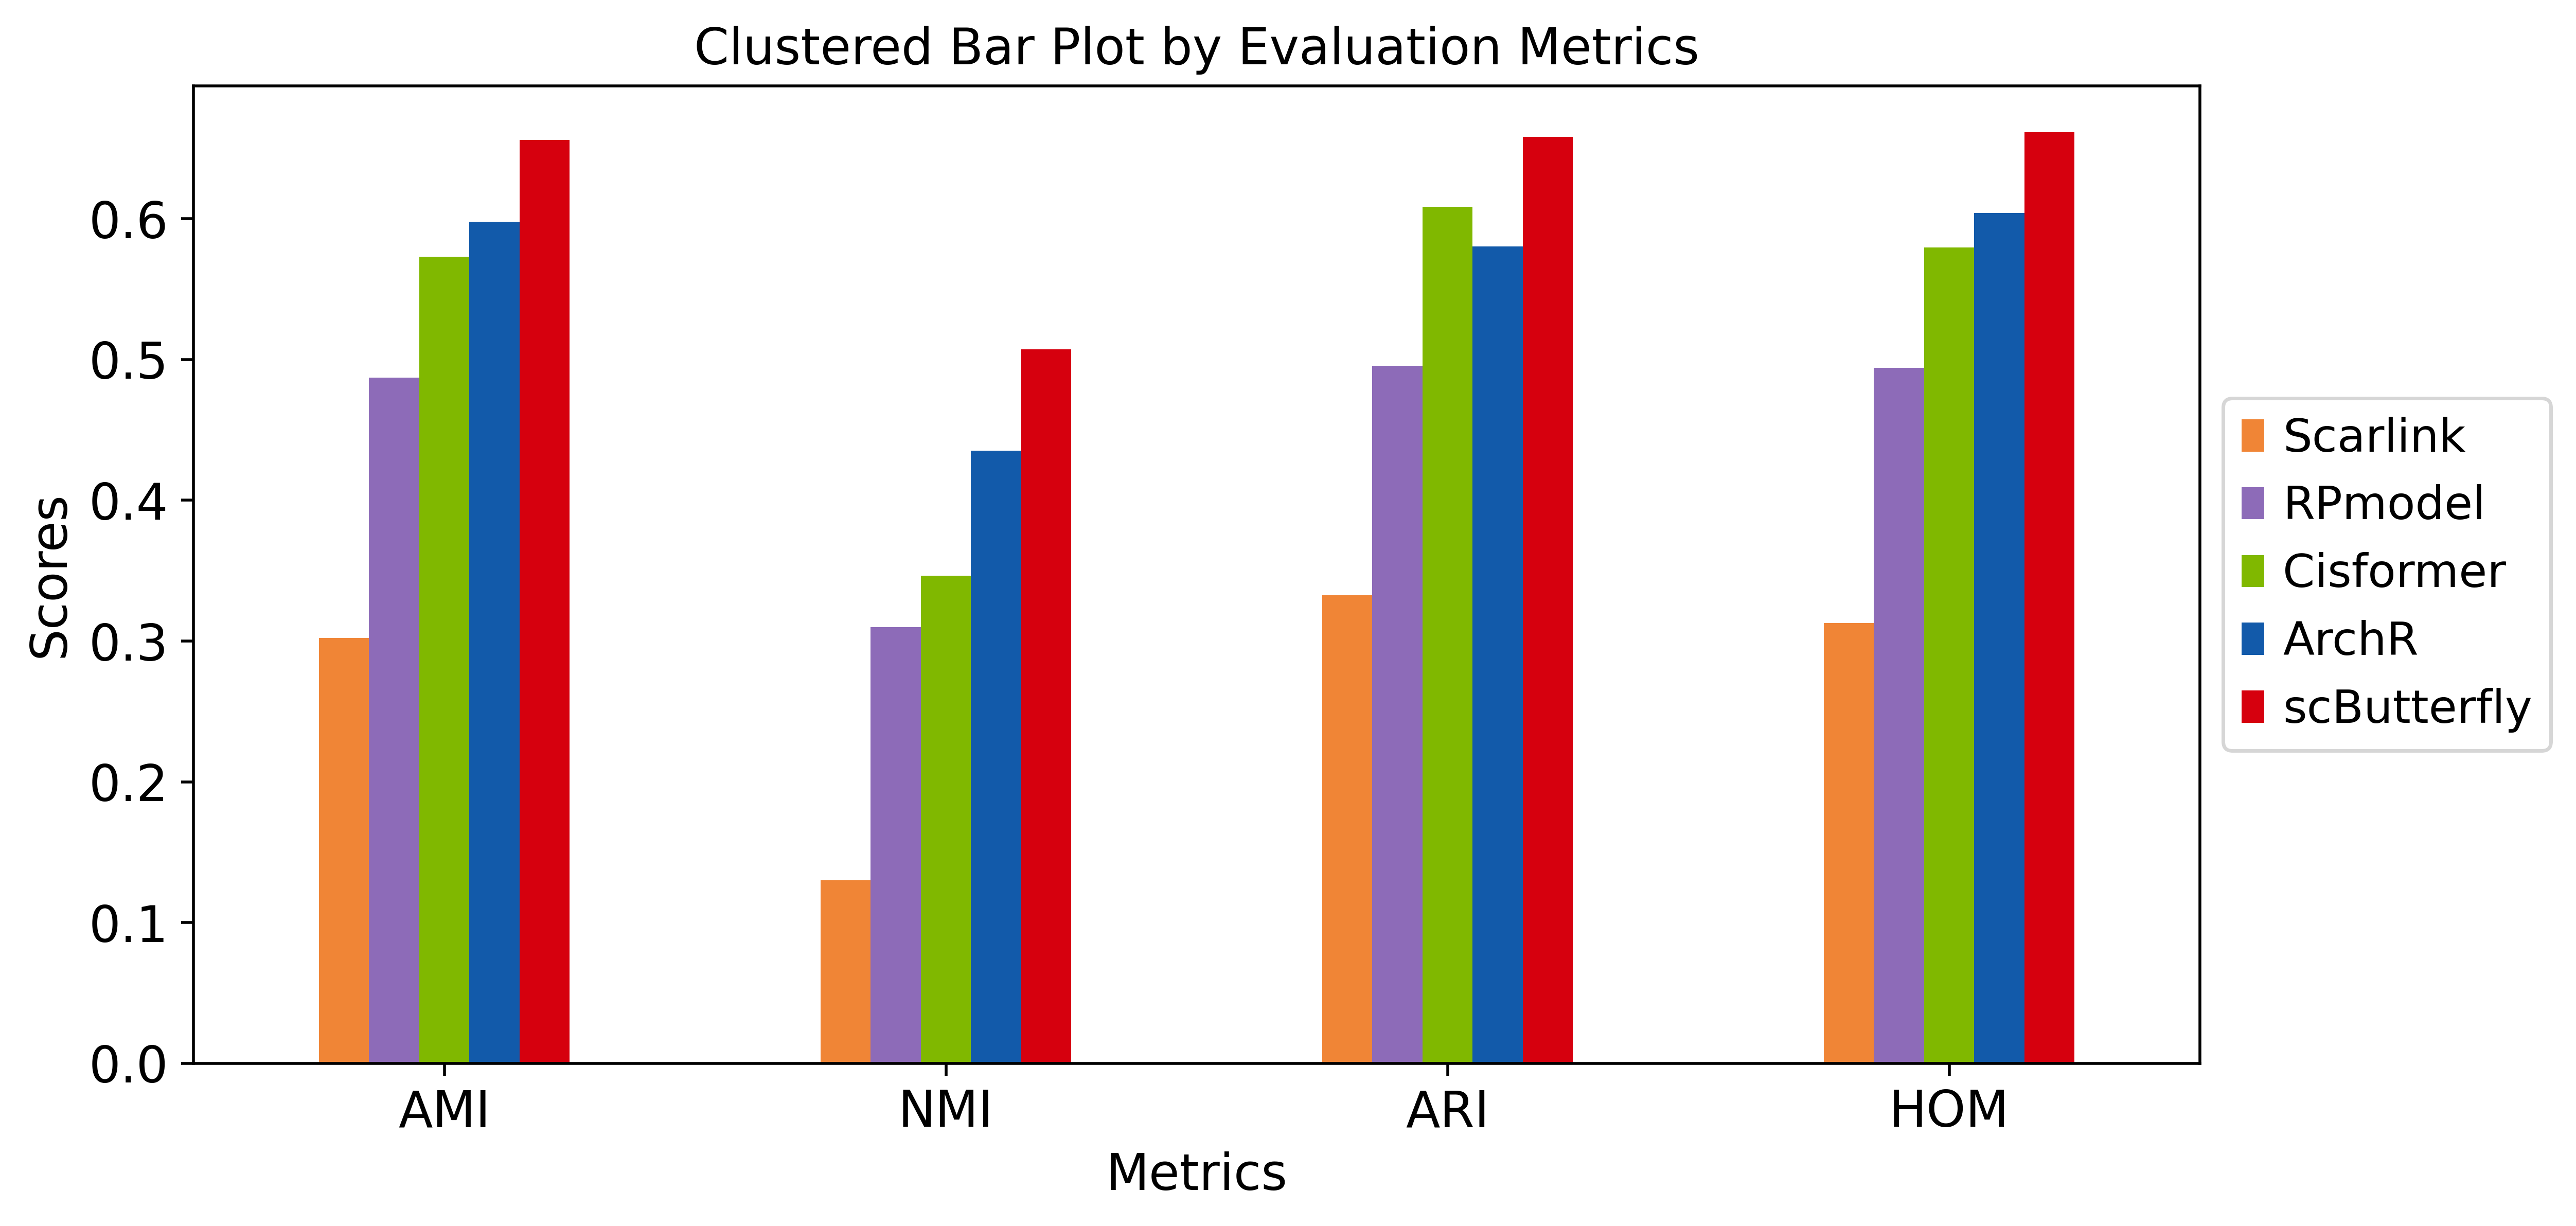

In [20]:
import pandas as pdcluster_eval_table_pd
import matplotlib.pyplot as plt
import numpy as np


# 绘制指标为 x 轴，模型作为簇中的元素的成簇柱状图
fig, ax = plt.subplots(figsize=(10, 5))

# 颜色列表，粉蓝色系且不相同
colors = ['#F08536', '#8D6BB8', '#80B800', '#125AAA', '#D6000E']

# 转置数据框，使指标作为 x 轴
df_transposed = cluster_eval_table_pd.T

# 绘制成簇柱状图
df_transposed.plot(kind='bar', ax=ax, color=colors)

# 添加标题和标签
plt.title('Clustered Bar Plot by Evaluation Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')

# 去掉灰色网格线
ax.grid(False)

# 将图例放在右侧
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 保存图形
plt.xticks(rotation=0)  # x轴标签保持水平
plt.savefig(os.path.join(fig_output_dir, "celltype_cluster_bar_plot.pdf"), dpi=600, bbox_inches='tight')

### Scatter plot

#### ArchR

/tmp/ipykernel_42159/1077032478.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  compare(predict_rna, archr_rna, raw_rna, title = "Cisformer vs ArchR on Tumor_B dataset", xlabel = "cisformer", ylabel = "ArchR Gene Score", save_dir = os.path.join(fig_output_dir), save_name = "CA_scatter")
/tmp/ipykernel_42159/2609559573.py:184: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  other_tool_rna.X[raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/

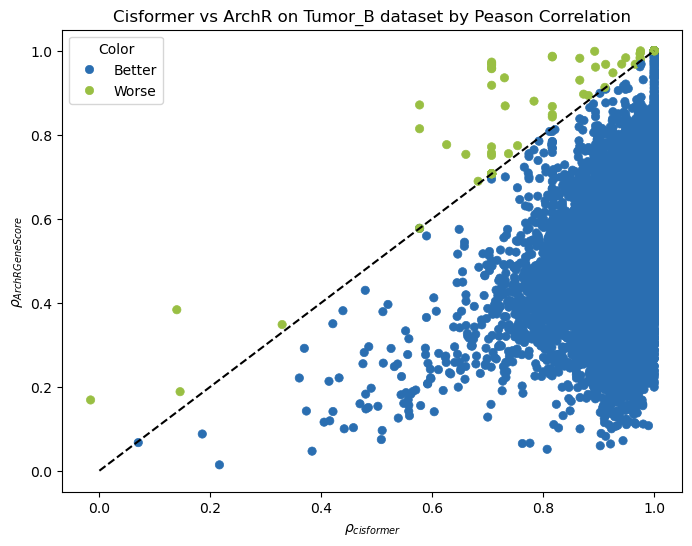

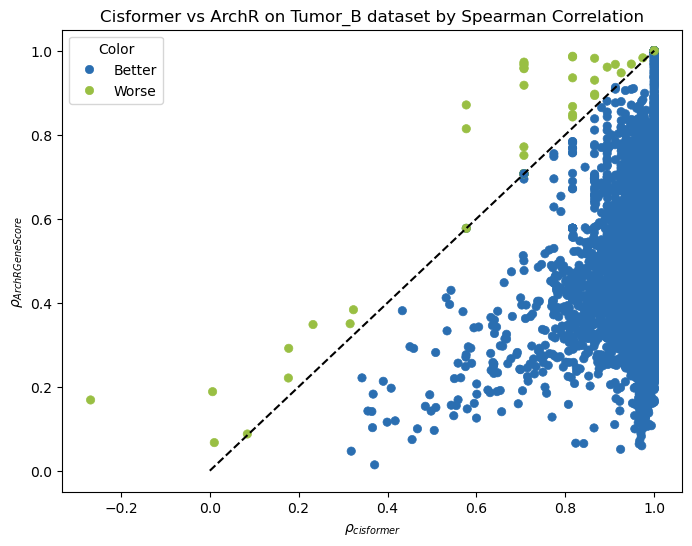

In [10]:
compare(predict_rna, archr_rna, raw_rna, title = "Cisformer vs ArchR on Tumor_B dataset", xlabel = "cisformer", ylabel = "ArchR Gene Score", save_dir = os.path.join(fig_output_dir), save_name = "CA_scatter")

#### Scarlink

/tmp/ipykernel_42159/2403508993.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  compare(predict_rna, scarlink_rna, raw_rna, title = "Cisformer vs Scarlink on Tumor_B dataset", xlabel = "cisformer", ylabel = "Scarlink", save_dir = os.path.join(fig_output_dir), save_name = "CS_scatter")
/tmp/ipykernel_42159/2609559573.py:184: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  other_tool_rna.X[raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/tmp/ipykernel_42159/2609559573.py:55: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  predict_rna.var["peason_corr"] = raw_gp_corr_value
/tmp/ipykernel_42159/2609559573.py:69: ConstantInputWarning: An in

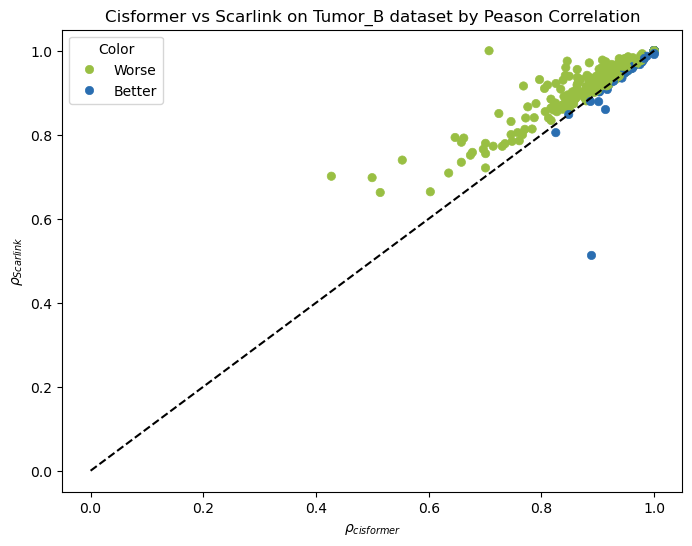

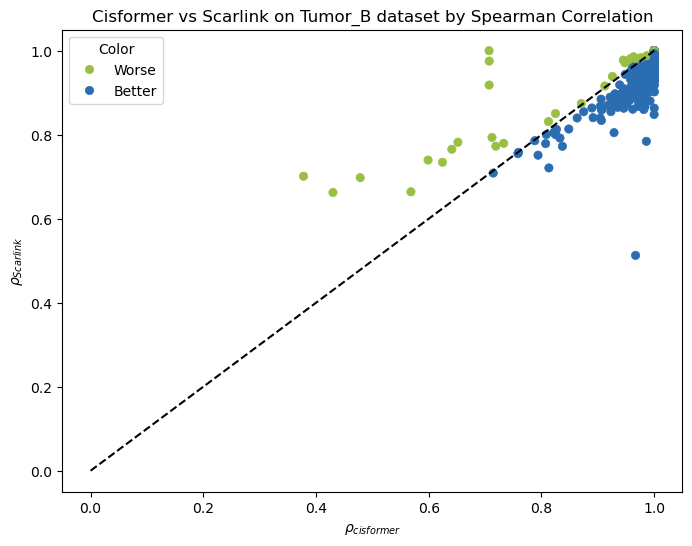

In [11]:
compare(predict_rna, scarlink_rna, raw_rna, title = "Cisformer vs Scarlink on Tumor_B dataset", xlabel = "cisformer", ylabel = "Scarlink", save_dir = os.path.join(fig_output_dir), save_name = "CS_scatter")

#### scButterfly

/tmp/ipykernel_42159/3897463579.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  compare(predict_rna, scbutterfly_rna, raw_rna, title = "Cisformer vs scButterfly on Tumor_B dataset", xlabel = "cisformer", ylabel = "scButterfly", save_dir = os.path.join(fig_output_dir), save_name = "Cs_scatter")
/tmp/ipykernel_42159/2609559573.py:184: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  other_tool_rna.X[raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, 

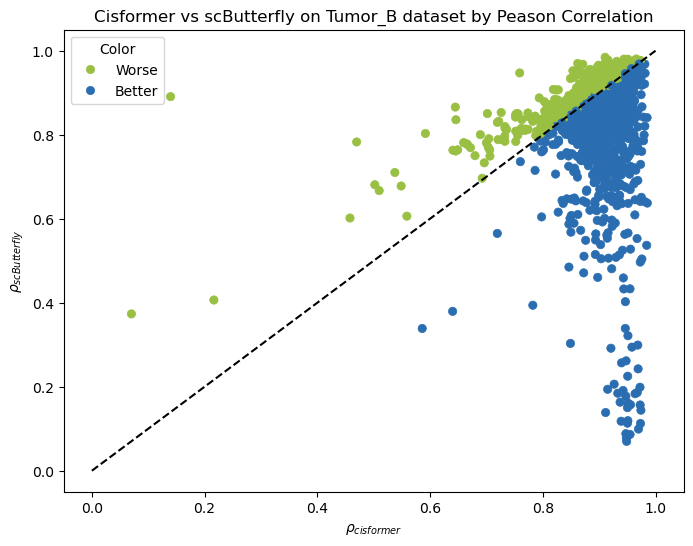

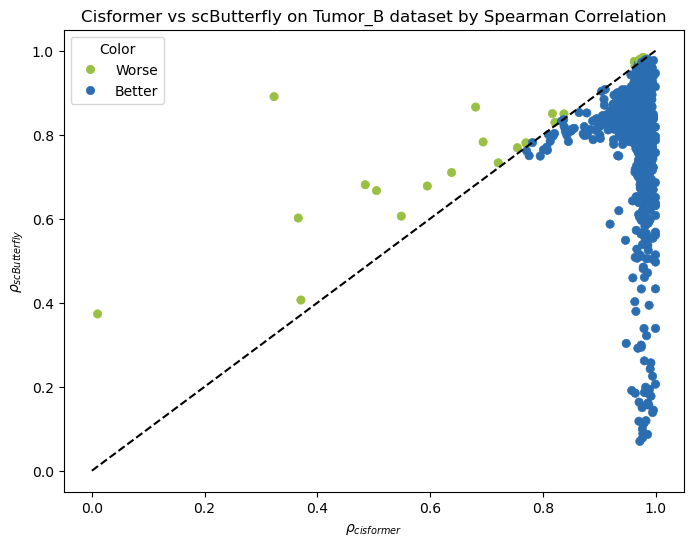

In [12]:
compare(predict_rna, scbutterfly_rna, raw_rna, title = "Cisformer vs scButterfly on Tumor_B dataset", xlabel = "cisformer", ylabel = "scButterfly", save_dir = os.path.join(fig_output_dir), save_name = "Cs_scatter")

#### RPmodel

/tmp/ipykernel_42159/3645803234.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  compare(predict_rna, rp_rna, raw_rna, title = "Cisformer vs RPmodel on Tumor_B dataset", xlabel = "cisformer", ylabel = "RPmodel", save_dir = os.path.join(fig_output_dir), save_name = "CR_scatter")
/tmp/ipykernel_42159/2609559573.py:184: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  other_tool_rna.X[raw_rna.X == 0] = 0 # 将真实表达的非0位点强行改成0，为了对齐我们的模型
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/data/home/zouqihang/miniconda3/envs/cisformer/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/home/

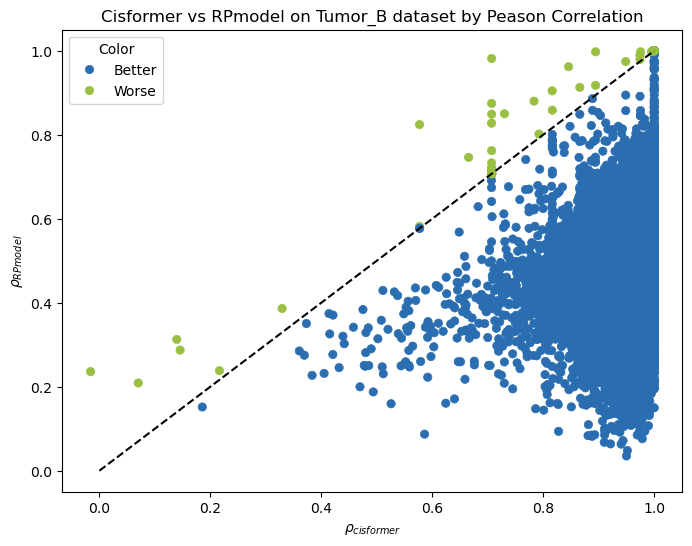

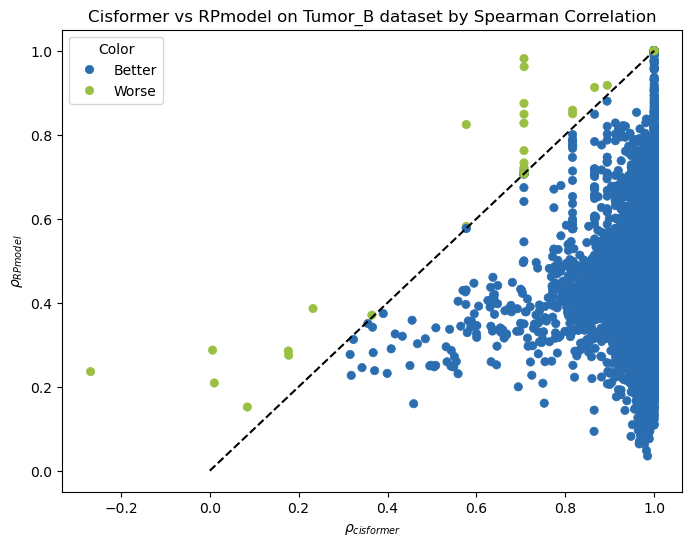

In [13]:
compare(predict_rna, rp_rna, raw_rna, title = "Cisformer vs RPmodel on Tumor_B dataset", xlabel = "cisformer", ylabel = "RPmodel", save_dir = os.path.join(fig_output_dir), save_name = "CR_scatter")